In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")
from src.nce.binary import NceBinaryCrit
from src.nce.cnce import CondNceCrit

from src.noise_distr.normal import MultivariateNormal
from src.noise_distr.conditional_normal import ConditionalMultivariateNormal

from src.models.ring_model.ring_model import RingModel, RingModelNCE, unnorm_ring_model_log_pdf
from src.data.ring_model_dataset import RingModelDataset

from src.training.model_training import train_model
from src.training.training_utils import PrecisionErrorMetric, no_change_stopping_condition

## EXPERIMENT HELP FUNCTIONS

In [2]:
# Noise distribution parameters, NCE

# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gNCEnoise.m
def get_nce_noise_distr_par(y):
    mu = torch.mean(y, dim=0)
    cov = torch.cov(torch.transpose(y, 0, 1))
    
    return mu, cov

In [3]:
# Noise distribution parameters, CNCE
# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gNoise.m

def get_cnce_epsilon_base(y):
    return torch.std(y, dim=-1).mean()

def get_cnce_covariance_matrix(epsilon_factor, epsilon_base, num_dims):
    return torch.eye(num_dims) * (epsilon_factor * epsilon_base)**2


# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gEpsilonBaseFun.m
def get_cnce_noise_distr_par(y, neg_sample_size, mu, log_precision):
    epsilon_factor = get_cnce_epsilon_factor(y, neg_sample_size, mu, log_precision)
    epsilon_base = get_cnce_epsilon_base(y)
    return get_cnce_covariance_matrix(epsilon_factor, epsilon_base, y.size(-1))


def evaluate_cnce_loss(epsilon_factor, neg_sample_size, p_m):
    
    epsilon_base = get_cnce_epsilon_base(y)
    cov_noise = get_cnce_covariance_matrix(epsilon_factor, epsilon_base, y.size(-1))
    
    p_n = ConditionalMultivariateNormal(cov=cov_noise)
    criterion = CondNceCrit(p_m, p_n)
    y_samples = criterion.sample_noise(neg_sample_size * y.size(0), y)
    
    return criterion.crit(y, y_samples)


def get_cnce_epsilon_factor(y, neg_sample_size, mu, log_precision, thrs_lower=0.05, thrs_upper=0.5, inc_rate=0.2, 
                            dec_rate=0.5, max_iter=500, eps_hard_cap=1000):
    
    loss_zero = np.log(2) # Loss as epsilon -> 0 
    loss_inf = 0  # Loss as epsilon -> inf
    thrs_upper = thrs_upper * loss_zero  
    
    num_dims = y.size(-1)
    p_m = RingModel(mu=mu, log_precision=log_precision)  
    
    epsilon_factor = 0.5  # Start value 

    # Calculate initial loss
    loss = evaluate_cnce_loss(epsilon_factor, neg_sample_size, p_m)

    # Iterate until conditions are met 
    k = 1;
    while (k < max_iter) and (abs(1 - (loss/loss_zero)) < thrs_lower or loss < thrs_upper ) and (epsilon_factor < eps_hard_cap):

        if abs(1 - (loss/loss_zero)) < thrs_lower: 
            epsilon_factor = (1 + inc_rate) * epsilon_factor
        elif loss < thrs_upper:
            epsilon_factor = (1 - dec_rate) * epsilon_factor
   
        loss = evaluate_cnce_loss(epsilon_factor, neg_sample_size, p_m)

        k = k + 1
    
    return epsilon_factor


In [4]:
# Generation of true parameters, parameter initialisation

# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/data_generation/generate_parameters.m
def generate_true_params(mu_min=5, mu_max=10, sigma_min=0.3, sigma_max=1.5):
    mu = (mu_max - mu_min) * torch.rand(1) + mu_min
    sigma = (sigma_max - sigma_min) * torch.rand(1) + sigma_min
    precision = sigma**(-2)
    z = -0.5 * torch.log(2 * torch.tensor(np.pi)) - torch.log(sigma) 
    
    return mu, precision, z

def initialise_params(mu_min=6, mu_max=8, sigma_min=0.3, sigma_max=1.5, z_min = 0.01):
    mu = (mu_max - mu_min) * torch.rand(1) + mu_min
    sigma = (sigma_max - sigma_min) * torch.rand(1) + sigma_min
    precision = sigma**(-2)
    
    z = torch.rand(1) + z_min

    return mu, torch.log(precision), torch.log(z)


## NOISE DISTRIBUTIONS PLOT

In [5]:
# Some helper functions
def get_grid_data(y_min=-10, y_max=10, grid_size=100):
    ny = np.linspace(y_min, y_max, grid_size)
    Y1, Y2 = np.meshgrid(ny, ny)
    y_grid = torch.tensor(np.column_stack((Y1.reshape(-1), Y2.reshape(-1))))
    
    return y_grid


def sample_nce(y, num_samples):
    mu_noise_nce, cov_noise_nce = get_nce_noise_distr_par(y)

    p_n = MultivariateNormal(mu=mu_noise_nce, cov=cov_noise_nce)
    return p_n.sample(torch.Size((num_samples,)))


def sample_cnce(y, num_samples, mu, log_precision, neg_sample_size=10):
    cov_noise = get_cnce_noise_distr_par(y, neg_sample_size, mu, log_precision)
    
    p_n = ConditionalMultivariateNormal(cov=cov_noise)
    
    return p_n.sample(torch.Size((num_samples,)), y)


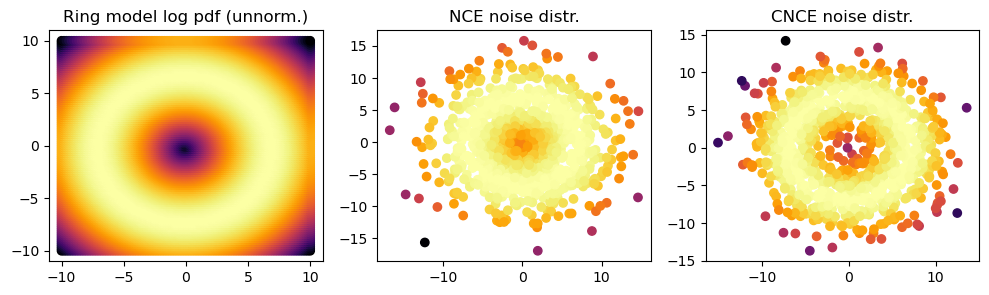

In [7]:
# 2D example
num_dims = 2
mu, precision = 7, 1


# Ring model pdf 
y_grid = get_grid_data()
log_pdf = unnorm_ring_model_log_pdf(y_grid, mu=mu, precision=precision)

# Sample from noise distr. based on some real training data
num_samples = 1000
y = RingModelDataset(sample_size=num_samples, num_dims=num_dims, mu=mu, precision=precision, 
                     root_dir="res/datasets/example_data").get_full_data()

# NCE 
y_samples_nce = sample_nce(y, num_samples)
log_pdf_nce = unnorm_ring_model_log_pdf(y_samples_nce, mu=mu, precision=precision)

# CNCE 
y_samples_cnce = sample_cnce(y, num_samples, mu, np.log(precision))
log_pdf_cnce = unnorm_ring_model_log_pdf(y_samples_cnce, mu=mu, precision=precision)


# Visualise
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].scatter(y_grid[:, 0], y_grid[:, 1], c=log_pdf, cmap='inferno')
ax[0].set_title("Ring model log pdf (unnorm.)")

ax[1].scatter(y_samples_nce[:, 0], y_samples_nce[:, 1], c=log_pdf_nce, cmap='inferno')
ax[1].set_title("NCE noise distr.")

ax[2].scatter(y_samples_cnce[:, 0], y_samples_cnce[:, 1], c=log_pdf_cnce, cmap='inferno')
ax[2].set_title("CNCE noise distr.")
            

plt.show()


## EXPERIMENTS

In [8]:
# Data specs
num_dims = 5

# Experiments specs
num_samples = [20, 50, 100, 200]
num_neg_samples = [2, 5, 10]
reps = 10

# Criteria 
criteria = [NceBinaryCrit, CondNceCrit]
crit_labels = ["binary", "conditional"]

# Training specs
batch_size = 32
num_epochs = 100

In [9]:
# Run experiments

error_res = np.zeros((len(num_samples), len(num_neg_samples), len(criteria), reps))

# Sorry för alla loopar
for i, N in enumerate(num_samples):
    
    for j, J in enumerate(num_neg_samples):
        
        for rep in range(reps):
            
            # Get data 
            mu, precision, _ = generate_true_params()
            error_metric = PrecisionErrorMetric(true_precision=precision).metric            
                        
            training_data = RingModelDataset(sample_size=N, num_dims=num_dims, mu=mu.numpy(), precision=precision.numpy(), 
                                             root_dir="res/datasets/ring_data_size_" + str(N) + "_nn_" + str(J) + "_rep_" + str(rep))
            train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
    
            # Initialise           
            _, log_precision_init, log_z_init = initialise_params()
    
            # Get noise distr. params
            mu_noise_nce, cov_noise_nce = get_nce_noise_distr_par(training_data.get_full_data())
            cov_noise_cnce = get_cnce_noise_distr_par(training_data.get_full_data(), J, mu, log_precision_init)
                        
            for k, (crit, lab) in enumerate(zip(criteria, crit_labels)):
            
                if crit == NceBinaryCrit: # TODO: Nicer way to do this comparison?
                    p_m = RingModelNCE(mu=mu, log_precision=log_precision_init, log_part_fn=log_z_init)
                else:
                    p_m = RingModel(mu=mu, log_precision=log_precision_init)
                    
                if crit == CondNceCrit:
                    p_n = ConditionalMultivariateNormal(cov=cov_noise_cnce)
                else:
                    p_n = MultivariateNormal(mu=mu_noise_nce, cov=cov_noise_nce)
                    
                criterion = crit(p_m, p_n)
                
                save_dir = "res/param_error_" + lab + "_samples_" + str(N) + "_num_neg_" + str(J) + "_rep_" + str(rep)
                error_res[i, j, k, rep] = train_model(criterion, error_metric, train_loader, save_dir, neg_sample_size=J, num_epochs=num_epochs,
                                                      stopping_condition=no_change_stopping_condition)

np.save("res/final_param_error_ring_model_all", error_res)

C:\Users\amaol67\PycharmProjects\deep_ext_obj\nbs\..\src\models\ring_model\ring_model.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_precision = torch.nn.Parameter(torch.tensor(log_precision), requires_grad=True)
C:\Users\amaol67\PycharmProjects\deep_ext_obj\nbs\..\src\models\ring_model\ring_model.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_part_fn = torch.nn.Parameter(torch.tensor(log_part_fn), requires_grad=True)


[1] loss: -1.839
[1] evaluation metric: 1.126
[2] loss: -1.925
[2] evaluation metric: 0.421
[3] loss: -2.258
[3] evaluation metric: 0.122
[4] loss: -2.471
[4] evaluation metric: 0.006
[5] loss: -2.694
[5] evaluation metric: 0.036
[6] loss: -2.698
[6] evaluation metric: 0.158
[7] loss: -2.516
[7] evaluation metric: 0.605
[8] loss: -2.876
[8] evaluation metric: 1.090
[9] loss: -2.672
[9] evaluation metric: 1.676
[10] loss: -3.015
[10] evaluation metric: 2.612
[11] loss: -2.638
[11] evaluation metric: 3.770
[12] loss: -2.817
[12] evaluation metric: 5.440
[13] loss: -2.840
[13] evaluation metric: 6.332
[14] loss: -2.926
[14] evaluation metric: 8.318
[15] loss: -2.794
[15] evaluation metric: 10.439
[16] loss: -2.669
[16] evaluation metric: 12.747
[17] loss: -2.902
[17] evaluation metric: 15.151
[18] loss: -2.830
[18] evaluation metric: 18.491
[19] loss: -2.823
[19] evaluation metric: 21.392
[20] loss: -2.776
[20] evaluation metric: 19.193
[21] loss: -3.095
[21] evaluation metric: 21.166
[22

[86] loss: 0.324
[86] evaluation metric: 0.541
[87] loss: 0.478
[87] evaluation metric: 0.537
[88] loss: 0.460
[88] evaluation metric: 0.527
[89] loss: 0.457
[89] evaluation metric: 0.526
[90] loss: 0.601
[90] evaluation metric: 0.549
[91] loss: 0.368
[91] evaluation metric: 0.526
[92] loss: 0.318
[92] evaluation metric: 0.522
[93] loss: 0.347
[93] evaluation metric: 0.513
[94] loss: 0.333
[94] evaluation metric: 0.495
[95] loss: 0.435
[95] evaluation metric: 0.485
[96] loss: 0.454
[96] evaluation metric: 0.480
[97] loss: 0.430
[97] evaluation metric: 0.489
[98] loss: 0.301
[98] evaluation metric: 0.471
[99] loss: 0.431
[99] evaluation metric: 0.444
[100] loss: 0.534
[100] evaluation metric: 0.451
Finished training
Data saved
[1] loss: -2.168
[1] evaluation metric: 0.675
[2] loss: -2.237
[2] evaluation metric: 0.939
[3] loss: -2.543
[3] evaluation metric: 1.281
[4] loss: -2.831
[4] evaluation metric: 1.484
[5] loss: -2.826
[5] evaluation metric: 1.808
[6] loss: -2.472
[6] evaluation me

[87] loss: 0.528
[87] evaluation metric: 0.002
[88] loss: 0.615
[88] evaluation metric: 0.002
[89] loss: 0.699
[89] evaluation metric: 0.003
[90] loss: 0.530
[90] evaluation metric: 0.003
[91] loss: 0.740
[91] evaluation metric: 0.004
[92] loss: 0.568
[92] evaluation metric: 0.004
[93] loss: 0.574
[93] evaluation metric: 0.004
[94] loss: 0.547
[94] evaluation metric: 0.004
[95] loss: 0.552
[95] evaluation metric: 0.004
[96] loss: 0.529
[96] evaluation metric: 0.004
[97] loss: 0.641
[97] evaluation metric: 0.004
[98] loss: 0.646
[98] evaluation metric: 0.004
[99] loss: 0.568
[99] evaluation metric: 0.004
[100] loss: 0.619
[100] evaluation metric: 0.005
Finished training
Data saved
[1] loss: -1.803
[1] evaluation metric: 0.410
[2] loss: -2.010
[2] evaluation metric: 0.621
[3] loss: -2.326
[3] evaluation metric: 1.077
[4] loss: -2.186
[4] evaluation metric: 1.666
[5] loss: -2.596
[5] evaluation metric: 2.300
[6] loss: -2.795
[6] evaluation metric: 2.571
[7] loss: -2.651
[7] evaluation met

[61] loss: 0.346
[61] evaluation metric: 0.281
[62] loss: 0.562
[62] evaluation metric: 0.263
[63] loss: 0.532
[63] evaluation metric: 0.249
[64] loss: 0.452
[64] evaluation metric: 0.239
[65] loss: 0.306
[65] evaluation metric: 0.248
[66] loss: 0.428
[66] evaluation metric: 0.247
[67] loss: 0.558
[67] evaluation metric: 0.236
[68] loss: 0.436
[68] evaluation metric: 0.236
[69] loss: 0.403
[69] evaluation metric: 0.232
[70] loss: 0.525
[70] evaluation metric: 0.221
[71] loss: 0.419
[71] evaluation metric: 0.221
[72] loss: 0.449
[72] evaluation metric: 0.224
[73] loss: 0.529
[73] evaluation metric: 0.213
[74] loss: 0.317
[74] evaluation metric: 0.220
[75] loss: 0.292
[75] evaluation metric: 0.228
[76] loss: 0.308
[76] evaluation metric: 0.235
[77] loss: 0.546
[77] evaluation metric: 0.224
[78] loss: 0.408
[78] evaluation metric: 0.231
[79] loss: 0.510
[79] evaluation metric: 0.224
[80] loss: 0.515
[80] evaluation metric: 0.212
[81] loss: 0.432
[81] evaluation metric: 0.209
[82] loss: 0.

[32] loss: 0.500
[32] evaluation metric: 0.983
[33] loss: 0.880
[33] evaluation metric: 0.855
[34] loss: 0.793
[34] evaluation metric: 0.774
[35] loss: 0.708
[35] evaluation metric: 0.717
[36] loss: 0.659
[36] evaluation metric: 0.678
[37] loss: 0.775
[37] evaluation metric: 0.611
[38] loss: 0.597
[38] evaluation metric: 0.589
[39] loss: 0.718
[39] evaluation metric: 0.548
[40] loss: 0.716
[40] evaluation metric: 0.508
[41] loss: 0.705
[41] evaluation metric: 0.472
[42] loss: 0.611
[42] evaluation metric: 0.444
[43] loss: 0.562
[43] evaluation metric: 0.436
[44] loss: 0.546
[44] evaluation metric: 0.428
[45] loss: 0.718
[45] evaluation metric: 0.397
[46] loss: 0.539
[46] evaluation metric: 0.392
[47] loss: 0.586
[47] evaluation metric: 0.377
[48] loss: 0.659
[48] evaluation metric: 0.356
[49] loss: 0.767
[49] evaluation metric: 0.326
[50] loss: 0.558
[50] evaluation metric: 0.309
[51] loss: 0.742
[51] evaluation metric: 0.281
[52] loss: 0.703
[52] evaluation metric: 0.257
[53] loss: 0.

[62] loss: 0.670
[62] evaluation metric: 0.006
[63] loss: 0.692
[63] evaluation metric: 0.006
[64] loss: 0.611
[64] evaluation metric: 0.006
[65] loss: 0.657
[65] evaluation metric: 0.006
[66] loss: 0.674
[66] evaluation metric: 0.006
[67] loss: 0.596
[67] evaluation metric: 0.006
[68] loss: 0.582
[68] evaluation metric: 0.006
[69] loss: 0.662
[69] evaluation metric: 0.006
[70] loss: 0.623
[70] evaluation metric: 0.006
[71] loss: 0.720
[71] evaluation metric: 0.007
[72] loss: 0.659
[72] evaluation metric: 0.007
[73] loss: 0.643
[73] evaluation metric: 0.007
[74] loss: 0.637
[74] evaluation metric: 0.007
[75] loss: 0.601
[75] evaluation metric: 0.007
[76] loss: 0.638
[76] evaluation metric: 0.007
[77] loss: 0.646
[77] evaluation metric: 0.007
[78] loss: 0.662
[78] evaluation metric: 0.007
[79] loss: 0.662
[79] evaluation metric: 0.007
[80] loss: 0.657
[80] evaluation metric: 0.007
[81] loss: 0.628
[81] evaluation metric: 0.007
[82] loss: 0.639
[82] evaluation metric: 0.007
[83] loss: 0.

[77] loss: 0.365
[77] evaluation metric: 0.062
[78] loss: 0.433
[78] evaluation metric: 0.062
[79] loss: 0.495
[79] evaluation metric: 0.060
[80] loss: 0.441
[80] evaluation metric: 0.063
[81] loss: 0.449
[81] evaluation metric: 0.065
[82] loss: 0.410
[82] evaluation metric: 0.067
[83] loss: 0.437
[83] evaluation metric: 0.071
[84] loss: 0.443
[84] evaluation metric: 0.072
[85] loss: 0.432
[85] evaluation metric: 0.074
[86] loss: 0.448
[86] evaluation metric: 0.075
[87] loss: 0.353
[87] evaluation metric: 0.079
[88] loss: 0.476
[88] evaluation metric: 0.079
[89] loss: 0.368
[89] evaluation metric: 0.083
[90] loss: 0.383
[90] evaluation metric: 0.089
[91] loss: 0.428
[91] evaluation metric: 0.094
[92] loss: 0.434
[92] evaluation metric: 0.093
[93] loss: 0.554
[93] evaluation metric: 0.092
[94] loss: 0.399
[94] evaluation metric: 0.092
[95] loss: 0.420
[95] evaluation metric: 0.094
[96] loss: 0.402
[96] evaluation metric: 0.094
[97] loss: 0.346
[97] evaluation metric: 0.100
[98] loss: 0.

[2] loss: -1.957
[2] evaluation metric: 8.007
[3] loss: -1.744
[3] evaluation metric: 7.007
[4] loss: -2.132
[4] evaluation metric: 6.092
[5] loss: -2.152
[5] evaluation metric: 5.022
[6] loss: -2.349
[6] evaluation metric: 4.234
[7] loss: -2.079
[7] evaluation metric: 3.513
[8] loss: -2.692
[8] evaluation metric: 3.139
[9] loss: -2.576
[9] evaluation metric: 2.442
[10] loss: -2.815
[10] evaluation metric: 2.039
[11] loss: -2.329
[11] evaluation metric: 1.374
[12] loss: -2.734
[12] evaluation metric: 0.896
[13] loss: -2.613
[13] evaluation metric: 0.297
[14] loss: -2.349
[14] evaluation metric: 0.078
[15] loss: -2.842
[15] evaluation metric: 0.030
[16] loss: -2.612
[16] evaluation metric: 0.002
[17] loss: -2.921
[17] evaluation metric: 0.014
[18] loss: -2.835
[18] evaluation metric: 0.160
[19] loss: -2.815
[19] evaluation metric: 0.619
[20] loss: -3.094
[20] evaluation metric: 0.771
[21] loss: -2.859
[21] evaluation metric: 1.332
[22] loss: -3.170
[22] evaluation metric: 1.642
[23] los

[31] loss: -3.020
[31] evaluation metric: 2.284
[32] loss: -2.337
[32] evaluation metric: 3.626
[33] loss: -3.028
[33] evaluation metric: 4.390
[34] loss: -2.690
[34] evaluation metric: 6.086
[35] loss: -2.893
[35] evaluation metric: 7.849
[36] loss: -2.484
[36] evaluation metric: 3.811
[37] loss: -3.000
[37] evaluation metric: 4.922
[38] loss: -2.771
[38] evaluation metric: 6.576
[39] loss: -3.160
[39] evaluation metric: 7.413
[40] loss: -2.992
[40] evaluation metric: 9.581
[41] loss: -0.776
[41] evaluation metric: 0.448
[42] loss: -2.495
[42] evaluation metric: 0.749
[43] loss: -2.633
[43] evaluation metric: 1.188
[44] loss: -2.669
[44] evaluation metric: 1.604
[45] loss: -2.531
[45] evaluation metric: 2.065
[46] loss: -3.072
[46] evaluation metric: 2.565
[47] loss: -2.443
[47] evaluation metric: 3.728
[48] loss: -3.016
[48] evaluation metric: 4.361
[49] loss: -2.016
[49] evaluation metric: 1.849
[50] loss: -2.582
[50] evaluation metric: 2.235
[51] loss: -2.829
[51] evaluation metric

[75] loss: -2.901
[75] evaluation metric: 4.462
[76] loss: -3.057
[76] evaluation metric: 4.924
[77] loss: -3.049
[77] evaluation metric: 6.015
[78] loss: -2.594
[78] evaluation metric: 7.667
[79] loss: -2.358
[79] evaluation metric: 10.565
[80] loss: -2.712
[80] evaluation metric: 14.604
[81] loss: -3.184
[81] evaluation metric: 15.887
[82] loss: -3.149
[82] evaluation metric: 18.857
[83] loss: -2.988
[83] evaluation metric: 22.784
[84] loss: -2.803
[84] evaluation metric: 25.821
[85] loss: -3.105
[85] evaluation metric: 28.991
[86] loss: -3.234
[86] evaluation metric: 31.310
[87] loss: -2.650
[87] evaluation metric: 17.644
[88] loss: -3.122
[88] evaluation metric: 22.340
[89] loss: -3.306
[89] evaluation metric: 23.421
[90] loss: -3.146
[90] evaluation metric: 25.302
[91] loss: -3.039
[91] evaluation metric: 27.165
[92] loss: -2.951
[92] evaluation metric: 32.227
[93] loss: -3.071
[93] evaluation metric: 36.179
[94] loss: -3.304
[94] evaluation metric: 38.916
[95] loss: -2.993
[95] e

[22] loss: 0.420
[22] evaluation metric: 2.731
[23] loss: 0.353
[23] evaluation metric: 2.713
[24] loss: 0.363
[24] evaluation metric: 2.694
[25] loss: 0.319
[25] evaluation metric: 2.675
[26] loss: 0.375
[26] evaluation metric: 2.650
[27] loss: 0.350
[27] evaluation metric: 2.620
[28] loss: 0.323
[28] evaluation metric: 2.582
[29] loss: 0.356
[29] evaluation metric: 2.545
[30] loss: 0.348
[30] evaluation metric: 2.522
[31] loss: 0.390
[31] evaluation metric: 2.507
[32] loss: 0.328
[32] evaluation metric: 2.467
[33] loss: 0.356
[33] evaluation metric: 2.433
[34] loss: 0.315
[34] evaluation metric: 2.391
[35] loss: 0.349
[35] evaluation metric: 2.377
[36] loss: 0.353
[36] evaluation metric: 2.349
[37] loss: 0.328
[37] evaluation metric: 2.312
[38] loss: 0.340
[38] evaluation metric: 2.290
[39] loss: 0.301
[39] evaluation metric: 2.252
[40] loss: 0.379
[40] evaluation metric: 2.237
[41] loss: 0.340
[41] evaluation metric: 2.213
[42] loss: 0.281
[42] evaluation metric: 2.186
[43] loss: 0.

[51] loss: 0.516
[51] evaluation metric: 0.031
[52] loss: 0.533
[52] evaluation metric: 0.031
[53] loss: 0.524
[53] evaluation metric: 0.030
[54] loss: 0.526
[54] evaluation metric: 0.029
[55] loss: 0.511
[55] evaluation metric: 0.028
[56] loss: 0.538
[56] evaluation metric: 0.027
[57] loss: 0.562
[57] evaluation metric: 0.027
[58] loss: 0.501
[58] evaluation metric: 0.027
[59] loss: 0.550
[59] evaluation metric: 0.026
[60] loss: 0.529
[60] evaluation metric: 0.025
[61] loss: 0.498
[61] evaluation metric: 0.024
[62] loss: 0.532
[62] evaluation metric: 0.023
[63] loss: 0.478
[63] evaluation metric: 0.022
[64] loss: 0.523
[64] evaluation metric: 0.021
[65] loss: 0.490
[65] evaluation metric: 0.021
[66] loss: 0.534
[66] evaluation metric: 0.020
[67] loss: 0.474
[67] evaluation metric: 0.019
[68] loss: 0.528
[68] evaluation metric: 0.019
[69] loss: 0.546
[69] evaluation metric: 0.019
[70] loss: 0.516
[70] evaluation metric: 0.018
[71] loss: 0.465
[71] evaluation metric: 0.017
[72] loss: 0.

[77] loss: 0.555
[77] evaluation metric: 0.098
[78] loss: 0.543
[78] evaluation metric: 0.099
[79] loss: 0.582
[79] evaluation metric: 0.100
[80] loss: 0.546
[80] evaluation metric: 0.101
[81] loss: 0.488
[81] evaluation metric: 0.100
[82] loss: 0.587
[82] evaluation metric: 0.102
[83] loss: 0.546
[83] evaluation metric: 0.103
[84] loss: 0.553
[84] evaluation metric: 0.103
[85] loss: 0.531
[85] evaluation metric: 0.104
[86] loss: 0.529
[86] evaluation metric: 0.103
[87] loss: 0.536
[87] evaluation metric: 0.103
[88] loss: 0.533
[88] evaluation metric: 0.103
[89] loss: 0.487
[89] evaluation metric: 0.102
[90] loss: 0.543
[90] evaluation metric: 0.103
[91] loss: 0.567
[91] evaluation metric: 0.105
[92] loss: 0.549
[92] evaluation metric: 0.106
[93] loss: 0.495
[93] evaluation metric: 0.106
[94] loss: 0.548
[94] evaluation metric: 0.107
[95] loss: 0.601
[95] evaluation metric: 0.110
[96] loss: 0.548
[96] evaluation metric: 0.110
[97] loss: 0.490
[97] evaluation metric: 0.110
[98] loss: 0.

[9] loss: -3.827
[9] evaluation metric: 0.522
[10] loss: -3.743
[10] evaluation metric: 0.705
[11] loss: -3.957
[11] evaluation metric: 0.884
[12] loss: -3.773
[12] evaluation metric: 1.256
[13] loss: -3.959
[13] evaluation metric: 1.509
[14] loss: -4.061
[14] evaluation metric: 1.848
[15] loss: -3.971
[15] evaluation metric: 2.246
[16] loss: -3.861
[16] evaluation metric: 2.845
[17] loss: -3.973
[17] evaluation metric: 3.577
[18] loss: -4.049
[18] evaluation metric: 4.098
[19] loss: -3.951
[19] evaluation metric: 4.908
[20] loss: -3.836
[20] evaluation metric: 5.226
[21] loss: -4.013
[21] evaluation metric: 6.061
[22] loss: -4.002
[22] evaluation metric: 6.912
[23] loss: -4.166
[23] evaluation metric: 7.739
[24] loss: -3.986
[24] evaluation metric: 8.847
[25] loss: -4.124
[25] evaluation metric: 9.695
[26] loss: -3.964
[26] evaluation metric: 11.006
[27] loss: -4.142
[27] evaluation metric: 11.910
[28] loss: -3.948
[28] evaluation metric: 13.758
[29] loss: -4.171
[29] evaluation metri

[21] loss: -3.994
[21] evaluation metric: 16.794
[22] loss: -4.082
[22] evaluation metric: 19.620
[23] loss: -4.018
[23] evaluation metric: 21.249
[24] loss: -4.077
[24] evaluation metric: 24.390
[25] loss: -3.501
[25] evaluation metric: 8.979
[26] loss: -3.962
[26] evaluation metric: 10.433
[27] loss: -3.875
[27] evaluation metric: 12.269
[28] loss: -3.834
[28] evaluation metric: 13.935
[29] loss: -4.003
[29] evaluation metric: 15.241
[30] loss: -3.982
[30] evaluation metric: 17.807
[31] loss: -3.972
[31] evaluation metric: 20.569
[32] loss: -4.031
[32] evaluation metric: 23.812
[33] loss: -3.870
[33] evaluation metric: 24.334
[34] loss: -3.956
[34] evaluation metric: 26.612
[35] loss: -4.053
[35] evaluation metric: 29.977
[36] loss: -2.879
[36] evaluation metric: 5.899
[37] loss: -3.751
[37] evaluation metric: 7.235
[38] loss: -3.575
[38] evaluation metric: 8.469
[39] loss: -3.860
[39] evaluation metric: 9.901
[40] loss: -2.721
[40] evaluation metric: 2.608
[41] loss: -3.551
[41] eva

[29] loss: -3.769
[29] evaluation metric: 8.363
[30] loss: -3.866
[30] evaluation metric: 9.336
[31] loss: -4.058
[31] evaluation metric: 10.574
[32] loss: -3.583
[32] evaluation metric: 9.632
[33] loss: -3.861
[33] evaluation metric: 10.852
[34] loss: -4.132
[34] evaluation metric: 12.241
[35] loss: -3.041
[35] evaluation metric: 4.285
[36] loss: -3.461
[36] evaluation metric: 3.966
[37] loss: -3.763
[37] evaluation metric: 4.742
[38] loss: -3.741
[38] evaluation metric: 5.399
[39] loss: -3.917
[39] evaluation metric: 6.460
[40] loss: -3.869
[40] evaluation metric: 7.768
[41] loss: -3.834
[41] evaluation metric: 9.379
[42] loss: -3.712
[42] evaluation metric: 8.329
[43] loss: -3.901
[43] evaluation metric: 9.603
[44] loss: -3.857
[44] evaluation metric: 9.732
[45] loss: -3.909
[45] evaluation metric: 11.727
[46] loss: -3.170
[46] evaluation metric: 6.628
[47] loss: -3.632
[47] evaluation metric: 6.738
[48] loss: -3.822
[48] evaluation metric: 7.978
[49] loss: -3.262
[49] evaluation me

[55] loss: -4.051
[55] evaluation metric: 39.293
[56] loss: -3.909
[56] evaluation metric: 44.855
[57] loss: -3.710
[57] evaluation metric: 35.921
[58] loss: -3.341
[58] evaluation metric: 24.983
[59] loss: -3.954
[59] evaluation metric: 29.059
[60] loss: -3.855
[60] evaluation metric: 32.780
[61] loss: -3.561
[61] evaluation metric: 23.529
[62] loss: -3.755
[62] evaluation metric: 27.234
[63] loss: -4.044
[63] evaluation metric: 30.261
[64] loss: -3.924
[64] evaluation metric: 34.162
[65] loss: -3.861
[65] evaluation metric: 32.893
[66] loss: -4.003
[66] evaluation metric: 37.597
[67] loss: -3.457
[67] evaluation metric: 24.575
[68] loss: -3.808
[68] evaluation metric: 26.102
[69] loss: -4.067
[69] evaluation metric: 29.118
[70] loss: -3.902
[70] evaluation metric: 34.355
[71] loss: -3.991
[71] evaluation metric: 40.356
[72] loss: -4.114
[72] evaluation metric: 45.075
[73] loss: -4.081
[73] evaluation metric: 49.053
[74] loss: -4.016
[74] evaluation metric: 57.528
[75] loss: -3.975
[7

[45] loss: -3.695
[45] evaluation metric: 25.334
[46] loss: 6.903
[46] evaluation metric: 0.155
[47] loss: -1.380
[47] evaluation metric: 0.511
[48] loss: -2.463
[48] evaluation metric: 0.828
[49] loss: -2.719
[49] evaluation metric: 1.168
[50] loss: -2.916
[50] evaluation metric: 1.495
[51] loss: -2.862
[51] evaluation metric: 2.333
[52] loss: -3.133
[52] evaluation metric: 2.945
[53] loss: -3.326
[53] evaluation metric: 3.783
[54] loss: -3.313
[54] evaluation metric: 4.966
[55] loss: -3.737
[55] evaluation metric: 5.933
[56] loss: -3.488
[56] evaluation metric: 7.075
[57] loss: -3.573
[57] evaluation metric: 8.678
[58] loss: -1.754
[58] evaluation metric: 1.106
[59] loss: -3.001
[59] evaluation metric: 1.392
[60] loss: -2.879
[60] evaluation metric: 2.005
[61] loss: -3.056
[61] evaluation metric: 2.782
[62] loss: -3.123
[62] evaluation metric: 3.864
[63] loss: -3.415
[63] evaluation metric: 4.677
[64] loss: -3.149
[64] evaluation metric: 6.107
[65] loss: -3.616
[65] evaluation metric

[85] loss: -2.776
[85] evaluation metric: 3.085
[86] loss: -3.287
[86] evaluation metric: 4.056
[87] loss: -3.605
[87] evaluation metric: 5.107
[88] loss: -3.594
[88] evaluation metric: 6.248
[89] loss: -2.828
[89] evaluation metric: 1.983
[90] loss: -3.318
[90] evaluation metric: 2.703
[91] loss: -3.354
[91] evaluation metric: 3.397
[92] loss: -3.295
[92] evaluation metric: 2.900
[93] loss: -3.382
[93] evaluation metric: 3.647
[94] loss: -3.416
[94] evaluation metric: 4.885
[95] loss: -3.599
[95] evaluation metric: 6.079
[96] loss: -3.589
[96] evaluation metric: 7.099
[97] loss: -3.752
[97] evaluation metric: 8.473
[98] loss: -3.548
[98] evaluation metric: 10.004
[99] loss: -3.839
[99] evaluation metric: 11.385
[100] loss: -1.414
[100] evaluation metric: 0.838
Finished training
Data saved
[1] loss: 0.588
[1] evaluation metric: 0.019
[2] loss: 0.595
[2] evaluation metric: 0.019
[3] loss: 0.616
[3] evaluation metric: 0.019
[4] loss: 0.592
[4] evaluation metric: 0.019
[5] loss: 0.628
[5]

[84] loss: -4.106
[84] evaluation metric: 1.071
[85] loss: -4.252
[85] evaluation metric: 1.389
[86] loss: -4.239
[86] evaluation metric: 1.789
[87] loss: -4.274
[87] evaluation metric: 2.169
[88] loss: -4.306
[88] evaluation metric: 2.673
[89] loss: -4.035
[89] evaluation metric: 2.437
[90] loss: -4.328
[90] evaluation metric: 2.908
[91] loss: -2.608
[91] evaluation metric: 0.448
[92] loss: -3.977
[92] evaluation metric: 0.709
[93] loss: -4.152
[93] evaluation metric: 1.029
[94] loss: -4.075
[94] evaluation metric: 1.413
[95] loss: -1.095
[95] evaluation metric: 0.063
[96] loss: -3.794
[96] evaluation metric: 0.139
[97] loss: -3.839
[97] evaluation metric: 0.259
[98] loss: -4.023
[98] evaluation metric: 0.412
[99] loss: -4.185
[99] evaluation metric: 0.613
[100] loss: -4.203
[100] evaluation metric: 0.852
Finished training
Data saved
[1] loss: 1.198
[1] evaluation metric: 36.724
[2] loss: 1.046
[2] evaluation metric: 30.453
[3] loss: 0.933
[3] evaluation metric: 25.874
[4] loss: 1.039

[8] loss: 0.754
[8] evaluation metric: 0.226
[9] loss: 0.748
[9] evaluation metric: 0.206
[10] loss: 0.815
[10] evaluation metric: 0.180
[11] loss: 0.735
[11] evaluation metric: 0.165
[12] loss: 0.715
[12] evaluation metric: 0.151
[13] loss: 0.778
[13] evaluation metric: 0.134
[14] loss: 0.680
[14] evaluation metric: 0.125
[15] loss: 0.679
[15] evaluation metric: 0.117
[16] loss: 0.676
[16] evaluation metric: 0.110
[17] loss: 0.733
[17] evaluation metric: 0.099
[18] loss: 0.660
[18] evaluation metric: 0.094
[19] loss: 0.720
[19] evaluation metric: 0.085
[20] loss: 0.722
[20] evaluation metric: 0.077
[21] loss: 0.691
[21] evaluation metric: 0.071
[22] loss: 0.704
[22] evaluation metric: 0.065
[23] loss: 0.685
[23] evaluation metric: 0.061
[24] loss: 0.688
[24] evaluation metric: 0.055
[25] loss: 0.699
[25] evaluation metric: 0.051
[26] loss: 0.727
[26] evaluation metric: 0.045
[27] loss: 0.670
[27] evaluation metric: 0.042
[28] loss: 0.695
[28] evaluation metric: 0.039
[29] loss: 0.709


[6] evaluation metric: 0.162
[7] loss: 0.642
[7] evaluation metric: 0.148
[8] loss: 0.687
[8] evaluation metric: 0.132
[9] loss: 0.694
[9] evaluation metric: 0.118
[10] loss: 0.693
[10] evaluation metric: 0.106
[11] loss: 0.659
[11] evaluation metric: 0.096
[12] loss: 0.699
[12] evaluation metric: 0.086
[13] loss: 0.703
[13] evaluation metric: 0.075
[14] loss: 0.636
[14] evaluation metric: 0.068
[15] loss: 0.729
[15] evaluation metric: 0.059
[16] loss: 0.647
[16] evaluation metric: 0.053
[17] loss: 0.644
[17] evaluation metric: 0.047
[18] loss: 0.601
[18] evaluation metric: 0.043
[19] loss: 0.668
[19] evaluation metric: 0.039
[20] loss: 0.635
[20] evaluation metric: 0.035
[21] loss: 0.636
[21] evaluation metric: 0.031
[22] loss: 0.616
[22] evaluation metric: 0.028
[23] loss: 0.554
[23] evaluation metric: 0.026
[24] loss: 0.624
[24] evaluation metric: 0.023
[25] loss: 0.615
[25] evaluation metric: 0.021
[26] loss: 0.601
[26] evaluation metric: 0.020
[27] loss: 0.616
[27] evaluation metr

[86] loss: -4.911
[86] evaluation metric: 20.633
[87] loss: -4.881
[87] evaluation metric: 21.884
[88] loss: -4.885
[88] evaluation metric: 22.702
[89] loss: -4.882
[89] evaluation metric: 24.428
[90] loss: -4.896
[90] evaluation metric: 26.545
[91] loss: -4.907
[91] evaluation metric: 28.232
[92] loss: -4.906
[92] evaluation metric: 29.787
[93] loss: -4.913
[93] evaluation metric: 32.016
[94] loss: -4.865
[94] evaluation metric: 33.505
[95] loss: -4.925
[95] evaluation metric: 36.451
[96] loss: -4.873
[96] evaluation metric: 38.107
[97] loss: -4.955
[97] evaluation metric: 40.191
[98] loss: -4.940
[98] evaluation metric: 43.476
[99] loss: -4.909
[99] evaluation metric: 45.994
[100] loss: -4.962
[100] evaluation metric: 48.430
Finished training
Data saved
[1] loss: 0.336
[1] evaluation metric: 3.151
[2] loss: 0.395
[2] evaluation metric: 3.120
[3] loss: 0.313
[3] evaluation metric: 3.084
[4] loss: 0.340
[4] evaluation metric: 3.045
[5] loss: 0.303
[5] evaluation metric: 3.008
[6] loss:

[76] loss: -4.225
[76] evaluation metric: 7.120
[77] loss: -4.480
[77] evaluation metric: 6.928
[78] loss: -3.354
[78] evaluation metric: 2.333
[79] loss: -4.076
[79] evaluation metric: 2.523
[80] loss: -4.350
[80] evaluation metric: 2.898
[81] loss: -4.321
[81] evaluation metric: 3.491
[82] loss: -4.267
[82] evaluation metric: 4.111
[83] loss: -4.407
[83] evaluation metric: 4.790
[84] loss: -3.472
[84] evaluation metric: 3.278
[85] loss: -4.241
[85] evaluation metric: 3.850
[86] loss: -4.383
[86] evaluation metric: 4.486
[87] loss: -4.491
[87] evaluation metric: 5.124
[88] loss: -4.333
[88] evaluation metric: 5.405
[89] loss: -4.352
[89] evaluation metric: 6.227
[90] loss: -4.437
[90] evaluation metric: 7.049
[91] loss: -4.256
[91] evaluation metric: 7.047
[92] loss: -4.534
[92] evaluation metric: 7.875
[93] loss: -3.969
[93] evaluation metric: 5.853
[94] loss: -3.377
[94] evaluation metric: 3.577
[95] loss: 4.144
[95] evaluation metric: 0.080
[96] loss: -3.797
[96] evaluation metric:

[53] loss: -4.213
[53] evaluation metric: 2.385
[54] loss: -4.396
[54] evaluation metric: 2.889
[55] loss: -3.600
[55] evaluation metric: 1.555
[56] loss: -4.108
[56] evaluation metric: 1.893
[57] loss: -4.138
[57] evaluation metric: 2.340
[58] loss: -4.174
[58] evaluation metric: 2.965
[59] loss: -3.979
[59] evaluation metric: 3.219
[60] loss: -4.416
[60] evaluation metric: 3.931
[61] loss: -4.289
[61] evaluation metric: 4.626
[62] loss: -3.817
[62] evaluation metric: 2.614
[63] loss: -4.232
[63] evaluation metric: 3.164
[64] loss: -4.304
[64] evaluation metric: 3.845
[65] loss: -3.782
[65] evaluation metric: 2.586
[66] loss: -4.186
[66] evaluation metric: 2.751
[67] loss: -4.034
[67] evaluation metric: 2.816
[68] loss: -4.082
[68] evaluation metric: 3.018
[69] loss: -3.622
[69] evaluation metric: 1.609
[70] loss: -3.998
[70] evaluation metric: 2.132
[71] loss: -4.151
[71] evaluation metric: 2.604
[72] loss: -4.333
[72] evaluation metric: 3.228
[73] loss: -4.514
[73] evaluation metric

[44] loss: -4.343
[44] evaluation metric: 2.960
[45] loss: -4.211
[45] evaluation metric: 3.498
[46] loss: -4.409
[46] evaluation metric: 4.082
[47] loss: -3.238
[47] evaluation metric: 2.072
[48] loss: 0.270
[48] evaluation metric: 0.145
[49] loss: -3.615
[49] evaluation metric: 0.262
[50] loss: -4.098
[50] evaluation metric: 0.347
[51] loss: -3.894
[51] evaluation metric: 0.448
[52] loss: -3.921
[52] evaluation metric: 0.604
[53] loss: -3.915
[53] evaluation metric: 0.846
[54] loss: -4.100
[54] evaluation metric: 1.027
[55] loss: -4.139
[55] evaluation metric: 1.273
[56] loss: -4.293
[56] evaluation metric: 1.595
[57] loss: -4.233
[57] evaluation metric: 1.916
[58] loss: -4.338
[58] evaluation metric: 2.294
[59] loss: -4.418
[59] evaluation metric: 2.704
[60] loss: -4.372
[60] evaluation metric: 2.985
[61] loss: -4.289
[61] evaluation metric: 3.524
[62] loss: -4.348
[62] evaluation metric: 4.082
[63] loss: -4.387
[63] evaluation metric: 4.668
[64] loss: -1.820
[64] evaluation metric:

[35] loss: -4.776
[35] evaluation metric: 10.980
[36] loss: -4.834
[36] evaluation metric: 12.618
[37] loss: -4.818
[37] evaluation metric: 13.898
[38] loss: -4.883
[38] evaluation metric: 15.226
[39] loss: -4.849
[39] evaluation metric: 16.916
[40] loss: -4.876
[40] evaluation metric: 19.057
[41] loss: -4.823
[41] evaluation metric: 20.854
[42] loss: -4.938
[42] evaluation metric: 22.312
[43] loss: -4.911
[43] evaluation metric: 23.291
[44] loss: -4.920
[44] evaluation metric: 24.983
[45] loss: -4.963
[45] evaluation metric: 26.577
[46] loss: -4.901
[46] evaluation metric: 29.070
[47] loss: -4.939
[47] evaluation metric: 31.575
[48] loss: -4.644
[48] evaluation metric: 21.066
[49] loss: -4.938
[49] evaluation metric: 22.714
[50] loss: -4.795
[50] evaluation metric: 23.414
[51] loss: -4.950
[51] evaluation metric: 25.496
[52] loss: -4.927
[52] evaluation metric: 27.702
[53] loss: -4.814
[53] evaluation metric: 30.457
[54] loss: -4.931
[54] evaluation metric: 32.701
[55] loss: -4.862
[5

[49] loss: -4.640
[49] evaluation metric: 5.045
[50] loss: -4.686
[50] evaluation metric: 5.551
[51] loss: -4.625
[51] evaluation metric: 6.670
[52] loss: -4.628
[52] evaluation metric: 7.846
[53] loss: -4.712
[53] evaluation metric: 8.898
[54] loss: -4.784
[54] evaluation metric: 10.030
[55] loss: -4.642
[55] evaluation metric: 10.821
[56] loss: -3.997
[56] evaluation metric: 6.306
[57] loss: -4.730
[57] evaluation metric: 7.016
[58] loss: -4.649
[58] evaluation metric: 7.614
[59] loss: -4.013
[59] evaluation metric: 3.901
[60] loss: -4.451
[60] evaluation metric: 4.466
[61] loss: -1.706
[61] evaluation metric: 0.054
[62] loss: -4.295
[62] evaluation metric: 0.092
[63] loss: -4.239
[63] evaluation metric: 0.142
[64] loss: -4.419
[64] evaluation metric: 0.292
[65] loss: -4.119
[65] evaluation metric: 0.361
[66] loss: -4.400
[66] evaluation metric: 0.621
[67] loss: -4.511
[67] evaluation metric: 0.876
[68] loss: -4.558
[68] evaluation metric: 1.106
[69] loss: -4.223
[69] evaluation metr

[68] loss: -4.634
[68] evaluation metric: 12.198
[69] loss: -4.796
[69] evaluation metric: 13.132
[70] loss: -4.781
[70] evaluation metric: 14.146
[71] loss: -4.758
[71] evaluation metric: 15.426
[72] loss: -3.222
[72] evaluation metric: 3.839
[73] loss: -4.567
[73] evaluation metric: 4.350
[74] loss: -4.461
[74] evaluation metric: 5.144
[75] loss: -4.715
[75] evaluation metric: 5.710
[76] loss: -4.269
[76] evaluation metric: 4.740
[77] loss: -4.426
[77] evaluation metric: 4.194
[78] loss: -4.530
[78] evaluation metric: 4.653
[79] loss: -4.519
[79] evaluation metric: 5.269
[80] loss: -4.609
[80] evaluation metric: 6.018
[81] loss: -4.378
[81] evaluation metric: 4.851
[82] loss: -4.637
[82] evaluation metric: 5.425
[83] loss: -4.516
[83] evaluation metric: 6.118
[84] loss: -4.588
[84] evaluation metric: 6.934
[85] loss: -4.637
[85] evaluation metric: 7.776
[86] loss: -4.628
[86] evaluation metric: 8.839
[87] loss: -4.738
[87] evaluation metric: 9.668
[88] loss: -4.754
[88] evaluation me

[63] loss: -6.081
[63] evaluation metric: 10.413
[64] loss: -5.785
[64] evaluation metric: 15.715
[65] loss: -6.505
[65] evaluation metric: 21.492
[66] loss: -6.443
[66] evaluation metric: 29.401
[67] loss: -3.742
[67] evaluation metric: 3.177
[68] loss: -5.392
[68] evaluation metric: 4.752
[69] loss: -5.789
[69] evaluation metric: 5.739
[70] loss: -6.318
[70] evaluation metric: 8.131
[71] loss: -6.031
[71] evaluation metric: 11.218
[72] loss: -6.327
[72] evaluation metric: 9.946
[73] loss: -6.004
[73] evaluation metric: 8.564
[74] loss: -6.090
[74] evaluation metric: 11.787
[75] loss: -6.257
[75] evaluation metric: 16.598
[76] loss: -6.418
[76] evaluation metric: 24.280
[77] loss: -6.578
[77] evaluation metric: 32.838
[78] loss: -6.803
[78] evaluation metric: 40.607
[79] loss: -4.384
[79] evaluation metric: 4.840
[80] loss: -5.759
[80] evaluation metric: 6.464
[81] loss: -5.694
[81] evaluation metric: 9.982
[82] loss: -6.261
[82] evaluation metric: 14.477
[83] loss: -5.762
[83] evalua

[47] loss: -7.033
[47] evaluation metric: 56.142
[48] loss: -6.906
[48] evaluation metric: 68.271
[49] loss: -6.766
[49] evaluation metric: 78.086
[50] loss: -7.192
[50] evaluation metric: 89.054
[51] loss: -7.069
[51] evaluation metric: 90.687
[52] loss: -6.790
[52] evaluation metric: 111.693
[53] loss: -6.870
[53] evaluation metric: 130.492
[54] loss: -3.972
[54] evaluation metric: 0.769
[55] loss: -6.664
[55] evaluation metric: 1.380
[56] loss: -6.466
[56] evaluation metric: 2.888
[57] loss: -6.518
[57] evaluation metric: 4.520
[58] loss: -6.717
[58] evaluation metric: 7.518
[59] loss: -6.464
[59] evaluation metric: 7.679
[60] loss: -6.723
[60] evaluation metric: 11.278
[61] loss: -6.757
[61] evaluation metric: 16.091
[62] loss: -6.425
[62] evaluation metric: 20.456
[63] loss: -6.872
[63] evaluation metric: 26.163
[64] loss: -7.063
[64] evaluation metric: 31.768
[65] loss: -6.798
[65] evaluation metric: 41.465
[66] loss: -6.476
[66] evaluation metric: 19.862
[67] loss: -6.696
[67] e

[47] loss: -6.838
[47] evaluation metric: 26.566
[48] loss: -6.357
[48] evaluation metric: 34.285
[49] loss: -6.792
[49] evaluation metric: 37.472
[50] loss: -6.794
[50] evaluation metric: 48.174
[51] loss: -6.965
[51] evaluation metric: 58.842
[52] loss: -6.925
[52] evaluation metric: 72.032
[53] loss: -6.753
[53] evaluation metric: 83.856
[54] loss: -6.749
[54] evaluation metric: 80.626
[55] loss: -6.891
[55] evaluation metric: 99.079
[56] loss: -7.055
[56] evaluation metric: 114.308
[57] loss: -7.188
[57] evaluation metric: 131.452
[58] loss: -7.140
[58] evaluation metric: 146.985
[59] loss: -7.066
[59] evaluation metric: 144.983
[60] loss: -7.109
[60] evaluation metric: 167.842
[61] loss: -7.190
[61] evaluation metric: 188.330
[62] loss: -7.071
[62] evaluation metric: 212.072
[63] loss: -7.196
[63] evaluation metric: 242.278
[64] loss: -6.774
[64] evaluation metric: 309.552
[65] loss: -7.186
[65] evaluation metric: 353.371
[66] loss: -7.211
[66] evaluation metric: 395.357
[67] loss

[49] loss: -5.116
[49] evaluation metric: 1.349
[50] loss: -5.279
[50] evaluation metric: 2.434
[51] loss: -5.727
[51] evaluation metric: 4.163
[52] loss: -3.919
[52] evaluation metric: 0.379
[53] loss: -4.253
[53] evaluation metric: 0.972
[54] loss: -5.242
[54] evaluation metric: 1.710
[55] loss: -5.430
[55] evaluation metric: 3.183
[56] loss: -5.582
[56] evaluation metric: 5.446
[57] loss: -6.138
[57] evaluation metric: 7.246
[58] loss: -1.135
[58] evaluation metric: 0.369
[59] loss: -4.028
[59] evaluation metric: 1.066
[60] loss: -4.989
[60] evaluation metric: 2.138
[61] loss: -5.625
[61] evaluation metric: 3.998
[62] loss: -3.533
[62] evaluation metric: 0.756
[63] loss: -4.684
[63] evaluation metric: 1.929
[64] loss: -5.407
[64] evaluation metric: 3.356
[65] loss: -5.552
[65] evaluation metric: 5.728
[66] loss: -6.151
[66] evaluation metric: 7.441
[67] loss: -6.289
[67] evaluation metric: 8.926
[68] loss: -6.600
[68] evaluation metric: 11.791
[69] loss: -6.699
[69] evaluation metri

[51] loss: 0.613
[51] evaluation metric: 0.254
[52] loss: 0.196
[52] evaluation metric: 0.250
[53] loss: -0.665
[53] evaluation metric: 0.245
[54] loss: -0.461
[54] evaluation metric: 0.242
[55] loss: -1.042
[55] evaluation metric: 0.238
[56] loss: -1.253
[56] evaluation metric: 0.235
[57] loss: -1.873
[57] evaluation metric: 0.229
[58] loss: -2.207
[58] evaluation metric: 0.224
[59] loss: -2.404
[59] evaluation metric: 0.215
[60] loss: -2.754
[60] evaluation metric: 0.208
[61] loss: -3.042
[61] evaluation metric: 0.200
[62] loss: -3.261
[62] evaluation metric: 0.193
[63] loss: -3.653
[63] evaluation metric: 0.183
[64] loss: -3.561
[64] evaluation metric: 0.176
[65] loss: -3.915
[65] evaluation metric: 0.166
[66] loss: -4.165
[66] evaluation metric: 0.156
[67] loss: -4.732
[67] evaluation metric: 0.149
[68] loss: -4.133
[68] evaluation metric: 0.141
[69] loss: -4.761
[69] evaluation metric: 0.132
[70] loss: -4.058
[70] evaluation metric: 0.116
[71] loss: -4.994
[71] evaluation metric: 

[68] loss: -6.137
[68] evaluation metric: 13.922
[69] loss: 2.258
[69] evaluation metric: 0.190
[70] loss: -3.407
[70] evaluation metric: 0.651
[71] loss: -4.588
[71] evaluation metric: 1.761
[72] loss: -4.862
[72] evaluation metric: 3.490
[73] loss: -5.796
[73] evaluation metric: 5.552
[74] loss: -0.864
[74] evaluation metric: 0.006
[75] loss: -2.963
[75] evaluation metric: 0.150
[76] loss: -3.728
[76] evaluation metric: 0.556
[77] loss: -4.789
[77] evaluation metric: 1.092
[78] loss: -5.377
[78] evaluation metric: 1.988
[79] loss: -5.443
[79] evaluation metric: 2.976
[80] loss: -5.256
[80] evaluation metric: 2.887
[81] loss: -5.217
[81] evaluation metric: 4.858
[82] loss: -6.168
[82] evaluation metric: 7.726
[83] loss: -5.975
[83] evaluation metric: 10.671
[84] loss: -6.205
[84] evaluation metric: 12.097
[85] loss: -5.625
[85] evaluation metric: 10.919
[86] loss: 1.021
[86] evaluation metric: 0.585
[87] loss: -3.859
[87] evaluation metric: 1.488
[88] loss: -5.547
[88] evaluation metr

[76] loss: -6.977
[76] evaluation metric: 19.094
[77] loss: -7.188
[77] evaluation metric: 23.989
[78] loss: -4.956
[78] evaluation metric: 2.017
[79] loss: -6.690
[79] evaluation metric: 3.515
[80] loss: -6.790
[80] evaluation metric: 4.955
[81] loss: -6.858
[81] evaluation metric: 6.750
[82] loss: -6.985
[82] evaluation metric: 8.174
[83] loss: -6.692
[83] evaluation metric: 11.387
[84] loss: -6.587
[84] evaluation metric: 6.950
[85] loss: -6.761
[85] evaluation metric: 8.839
[86] loss: -6.954
[86] evaluation metric: 10.920
[87] loss: -6.826
[87] evaluation metric: 13.484
[88] loss: -6.779
[88] evaluation metric: 16.934
[89] loss: -6.988
[89] evaluation metric: 23.940
[90] loss: -6.804
[90] evaluation metric: 33.000
[91] loss: -7.122
[91] evaluation metric: 38.231
[92] loss: -6.927
[92] evaluation metric: 31.557
[93] loss: -4.705
[93] evaluation metric: 1.760
[94] loss: -6.890
[94] evaluation metric: 2.450
[95] loss: -6.397
[95] evaluation metric: 3.321
[96] loss: -6.577
[96] evaluat

[89] loss: -5.561
[89] evaluation metric: 2.886
[90] loss: -5.816
[90] evaluation metric: 4.780
[91] loss: -4.642
[91] evaluation metric: 2.758
[92] loss: -4.875
[92] evaluation metric: 5.385
[93] loss: -5.744
[93] evaluation metric: 7.478
[94] loss: -5.793
[94] evaluation metric: 8.662
[95] loss: -6.139
[95] evaluation metric: 8.485
[96] loss: -2.667
[96] evaluation metric: 1.368
[97] loss: -5.077
[97] evaluation metric: 2.429
[98] loss: -5.738
[98] evaluation metric: 3.807
[99] loss: -5.404
[99] evaluation metric: 6.931
[100] loss: -5.916
[100] evaluation metric: 10.473
Finished training
Data saved
[1] loss: 1.243
[1] evaluation metric: 0.002
[2] loss: 1.130
[2] evaluation metric: 0.002
[3] loss: 1.099
[3] evaluation metric: 0.002
[4] loss: 1.154
[4] evaluation metric: 0.002
[5] loss: 1.339
[5] evaluation metric: 0.002
[6] loss: 1.077
[6] evaluation metric: 0.002
[7] loss: 1.149
[7] evaluation metric: 0.002
[8] loss: 1.118
[8] evaluation metric: 0.002
[9] loss: 1.217
[9] evaluation m

[72] loss: -6.363
[72] evaluation metric: 12.083
[73] loss: -6.529
[73] evaluation metric: 18.040
[74] loss: -6.267
[74] evaluation metric: 21.400
[75] loss: -6.587
[75] evaluation metric: 28.739
[76] loss: -6.943
[76] evaluation metric: 35.071
[77] loss: -6.860
[77] evaluation metric: 38.548
[78] loss: -7.168
[78] evaluation metric: 46.833
[79] loss: -7.188
[79] evaluation metric: 56.295
[80] loss: -3.348
[80] evaluation metric: 7.484
[81] loss: -6.157
[81] evaluation metric: 10.449
[82] loss: -6.593
[82] evaluation metric: 14.244
[83] loss: -2.552
[83] evaluation metric: 2.495
[84] loss: -5.568
[84] evaluation metric: 3.965
[85] loss: -2.161
[85] evaluation metric: 0.341
[86] loss: -4.075
[86] evaluation metric: 1.060
[87] loss: -5.128
[87] evaluation metric: 1.870
[88] loss: -5.607
[88] evaluation metric: 2.968
[89] loss: -5.722
[89] evaluation metric: 4.678
[90] loss: -5.550
[90] evaluation metric: 4.600
[91] loss: -5.844
[91] evaluation metric: 6.653
[92] loss: -6.291
[92] evaluat

[54] loss: -6.187
[54] evaluation metric: 30.648
[55] loss: -2.759
[55] evaluation metric: 4.159
[56] loss: -4.983
[56] evaluation metric: 6.765
[57] loss: -3.418
[57] evaluation metric: 3.613
[58] loss: -2.862
[58] evaluation metric: 0.877
[59] loss: -4.039
[59] evaluation metric: 2.432
[60] loss: -5.220
[60] evaluation metric: 5.189
[61] loss: 2.037
[61] evaluation metric: 0.000
[62] loss: -1.193
[62] evaluation metric: 0.073
[63] loss: -1.596
[63] evaluation metric: 1.208
[64] loss: -3.323
[64] evaluation metric: 3.270
[65] loss: 0.105
[65] evaluation metric: 0.006
[66] loss: -1.929
[66] evaluation metric: 0.275
[67] loss: -2.375
[67] evaluation metric: 1.046
[68] loss: -3.472
[68] evaluation metric: 3.323
[69] loss: -5.057
[69] evaluation metric: 6.384
[70] loss: -5.359
[70] evaluation metric: 10.533
[71] loss: -6.111
[71] evaluation metric: 16.829
[72] loss: -6.194
[72] evaluation metric: 23.890
[73] loss: -6.387
[73] evaluation metric: 22.319
[74] loss: 12.690
[74] evaluation met

[27] loss: -6.290
[27] evaluation metric: 1.327
[28] loss: -7.500
[28] evaluation metric: 2.124
[29] loss: -7.725
[29] evaluation metric: 3.197
[30] loss: -7.933
[30] evaluation metric: 4.359
[31] loss: -8.080
[31] evaluation metric: 5.792
[32] loss: -8.158
[32] evaluation metric: 7.601
[33] loss: -3.526
[33] evaluation metric: 0.046
[34] loss: -6.451
[34] evaluation metric: 0.209
[35] loss: -7.136
[35] evaluation metric: 0.465
[36] loss: -7.580
[36] evaluation metric: 0.829
[37] loss: -7.291
[37] evaluation metric: 1.470
[38] loss: -7.307
[38] evaluation metric: 2.364
[39] loss: -6.433
[39] evaluation metric: 0.543
[40] loss: -7.427
[40] evaluation metric: 1.066
[41] loss: -7.599
[41] evaluation metric: 1.730
[42] loss: -7.765
[42] evaluation metric: 2.431
[43] loss: -7.753
[43] evaluation metric: 3.402
[44] loss: -8.035
[44] evaluation metric: 4.403
[45] loss: -7.805
[45] evaluation metric: 4.848
[46] loss: -8.113
[46] evaluation metric: 6.477
[47] loss: -8.414
[47] evaluation metric

[32] loss: -8.218
[32] evaluation metric: 29.293
[33] loss: -8.322
[33] evaluation metric: 35.515
[34] loss: -8.377
[34] evaluation metric: 43.574
[35] loss: -8.540
[35] evaluation metric: 52.302
[36] loss: -8.612
[36] evaluation metric: 64.562
[37] loss: -3.500
[37] evaluation metric: 4.384
[38] loss: -7.602
[38] evaluation metric: 6.716
[39] loss: -7.885
[39] evaluation metric: 10.165
[40] loss: -8.061
[40] evaluation metric: 13.187
[41] loss: -7.623
[41] evaluation metric: 10.441
[42] loss: -8.110
[42] evaluation metric: 13.587
[43] loss: -7.970
[43] evaluation metric: 17.728
[44] loss: -8.448
[44] evaluation metric: 21.883
[45] loss: -8.280
[45] evaluation metric: 26.948
[46] loss: 5.451
[46] evaluation metric: 0.071
[47] loss: -4.948
[47] evaluation metric: 0.024
[48] loss: -6.230
[48] evaluation metric: 0.337
[49] loss: -6.636
[49] evaluation metric: 1.054
[50] loss: -7.111
[50] evaluation metric: 2.107
[51] loss: -7.232
[51] evaluation metric: 3.898
[52] loss: -7.490
[52] evalua

[28] loss: -8.323
[28] evaluation metric: 7.513
[29] loss: -8.320
[29] evaluation metric: 9.591
[30] loss: -8.513
[30] evaluation metric: 12.260
[31] loss: -8.186
[31] evaluation metric: 15.782
[32] loss: -7.385
[32] evaluation metric: 7.632
[33] loss: -8.356
[33] evaluation metric: 10.224
[34] loss: -7.610
[34] evaluation metric: 6.074
[35] loss: -8.244
[35] evaluation metric: 7.753
[36] loss: -7.722
[36] evaluation metric: 6.066
[37] loss: -8.284
[37] evaluation metric: 8.276
[38] loss: -8.431
[38] evaluation metric: 10.464
[39] loss: -8.466
[39] evaluation metric: 13.050
[40] loss: -8.346
[40] evaluation metric: 16.669
[41] loss: -8.472
[41] evaluation metric: 20.248
[42] loss: -8.551
[42] evaluation metric: 26.215
[43] loss: -8.514
[43] evaluation metric: 31.861
[44] loss: -8.648
[44] evaluation metric: 37.513
[45] loss: -8.597
[45] evaluation metric: 45.026
[46] loss: -8.453
[46] evaluation metric: 55.177
[47] loss: -8.670
[47] evaluation metric: 65.027
[48] loss: -8.298
[48] eval

[1] loss: -4.461
[1] evaluation metric: 1.906
[2] loss: -5.432
[2] evaluation metric: 1.138
[3] loss: -6.122
[3] evaluation metric: 0.626
[4] loss: -6.636
[4] evaluation metric: 0.263
[5] loss: -7.288
[5] evaluation metric: 0.047
[6] loss: -7.377
[6] evaluation metric: 0.004
[7] loss: -7.497
[7] evaluation metric: 0.090
[8] loss: -7.671
[8] evaluation metric: 0.312
[9] loss: -7.638
[9] evaluation metric: 1.037
[10] loss: -8.198
[10] evaluation metric: 1.750
[11] loss: -7.978
[11] evaluation metric: 3.068
[12] loss: -8.282
[12] evaluation metric: 4.533
[13] loss: -8.475
[13] evaluation metric: 6.126
[14] loss: -8.193
[14] evaluation metric: 8.269
[15] loss: -8.457
[15] evaluation metric: 10.528
[16] loss: -8.361
[16] evaluation metric: 13.178
[17] loss: -8.396
[17] evaluation metric: 16.586
[18] loss: -8.478
[18] evaluation metric: 18.097
[19] loss: -8.672
[19] evaluation metric: 21.865
[20] loss: -8.483
[20] evaluation metric: 27.906
[21] loss: -8.758
[21] evaluation metric: 33.166
[22

[79] loss: 0.721
[79] evaluation metric: 0.587
[80] loss: 0.677
[80] evaluation metric: 0.568
[81] loss: 0.744
[81] evaluation metric: 0.569
[82] loss: 0.602
[82] evaluation metric: 0.548
[83] loss: 0.673
[83] evaluation metric: 0.543
[84] loss: 0.609
[84] evaluation metric: 0.529
[85] loss: 0.570
[85] evaluation metric: 0.508
[86] loss: 0.680
[86] evaluation metric: 0.503
[87] loss: 0.674
[87] evaluation metric: 0.491
[88] loss: 0.560
[88] evaluation metric: 0.467
[89] loss: 0.666
[89] evaluation metric: 0.453
[90] loss: 0.743
[90] evaluation metric: 0.463
[91] loss: 0.676
[91] evaluation metric: 0.446
[92] loss: 0.744
[92] evaluation metric: 0.451
[93] loss: 0.616
[93] evaluation metric: 0.433
[94] loss: 0.640
[94] evaluation metric: 0.424
[95] loss: 0.618
[95] evaluation metric: 0.413
[96] loss: 0.699
[96] evaluation metric: 0.415
[97] loss: 0.611
[97] evaluation metric: 0.402
[98] loss: 0.647
[98] evaluation metric: 0.394
[99] loss: 0.674
[99] evaluation metric: 0.384
[100] loss: 0

[55] loss: 0.612
[55] evaluation metric: 0.189
[56] loss: 0.481
[56] evaluation metric: 0.195
[57] loss: 0.546
[57] evaluation metric: 0.201
[58] loss: 0.622
[58] evaluation metric: 0.208
[59] loss: 0.567
[59] evaluation metric: 0.210
[60] loss: 0.570
[60] evaluation metric: 0.213
[61] loss: 0.507
[61] evaluation metric: 0.224
[62] loss: 0.590
[62] evaluation metric: 0.232
[63] loss: 0.597
[63] evaluation metric: 0.231
[64] loss: 0.491
[64] evaluation metric: 0.243
[65] loss: 0.511
[65] evaluation metric: 0.258
[66] loss: 0.568
[66] evaluation metric: 0.268
[67] loss: 0.623
[67] evaluation metric: 0.267
[68] loss: 0.486
[68] evaluation metric: 0.275
[69] loss: 0.517
[69] evaluation metric: 0.297
[70] loss: 0.487
[70] evaluation metric: 0.306
[71] loss: 0.543
[71] evaluation metric: 0.324
[72] loss: 0.614
[72] evaluation metric: 0.330
[73] loss: 0.489
[73] evaluation metric: 0.346
[74] loss: 0.525
[74] evaluation metric: 0.358
[75] loss: 0.511
[75] evaluation metric: 0.376
[76] loss: 0.

[40] loss: 1.117
[40] evaluation metric: 0.017
[41] loss: 1.189
[41] evaluation metric: 0.018
[42] loss: 1.227
[42] evaluation metric: 0.021
[43] loss: 1.156
[43] evaluation metric: 0.022
[44] loss: 1.231
[44] evaluation metric: 0.023
[45] loss: 1.216
[45] evaluation metric: 0.025
[46] loss: 1.157
[46] evaluation metric: 0.026
[47] loss: 1.239
[47] evaluation metric: 0.028
[48] loss: 1.139
[48] evaluation metric: 0.028
[49] loss: 1.241
[49] evaluation metric: 0.030
[50] loss: 1.093
[50] evaluation metric: 0.029
[51] loss: 1.254
[51] evaluation metric: 0.032
[52] loss: 1.198
[52] evaluation metric: 0.033
[53] loss: 1.091
[53] evaluation metric: 0.032
[54] loss: 1.206
[54] evaluation metric: 0.034
[55] loss: 1.276
[55] evaluation metric: 0.036
[56] loss: 1.142
[56] evaluation metric: 0.037
[57] loss: 1.094
[57] evaluation metric: 0.036
[58] loss: 1.277
[58] evaluation metric: 0.039
[59] loss: 1.179
[59] evaluation metric: 0.040
[60] loss: 1.318
[60] evaluation metric: 0.045
[61] loss: 1.

[15] loss: 1.241
[15] evaluation metric: 0.032
[16] loss: 1.194
[16] evaluation metric: 0.031
[17] loss: 1.222
[17] evaluation metric: 0.029
[18] loss: 1.197
[18] evaluation metric: 0.027
[19] loss: 1.226
[19] evaluation metric: 0.024
[20] loss: 1.228
[20] evaluation metric: 0.022
[21] loss: 1.130
[21] evaluation metric: 0.021
[22] loss: 1.173
[22] evaluation metric: 0.019
[23] loss: 1.301
[23] evaluation metric: 0.017
[24] loss: 1.238
[24] evaluation metric: 0.016
[25] loss: 1.219
[25] evaluation metric: 0.015
[26] loss: 1.195
[26] evaluation metric: 0.014
[27] loss: 1.230
[27] evaluation metric: 0.013
[28] loss: 1.064
[28] evaluation metric: 0.013
[29] loss: 1.219
[29] evaluation metric: 0.012
[30] loss: 1.123
[30] evaluation metric: 0.012
[31] loss: 1.333
[31] evaluation metric: 0.010
[32] loss: 1.194
[32] evaluation metric: 0.010
[33] loss: 1.204
[33] evaluation metric: 0.009
[34] loss: 1.129
[34] evaluation metric: 0.009
[35] loss: 1.244
[35] evaluation metric: 0.008
[36] loss: 1.

[20] loss: 1.010
[20] evaluation metric: 0.281
[21] loss: 1.044
[21] evaluation metric: 0.268
[22] loss: 1.056
[22] evaluation metric: 0.259
[23] loss: 0.983
[23] evaluation metric: 0.260
[24] loss: 0.959
[24] evaluation metric: 0.254
[25] loss: 0.926
[25] evaluation metric: 0.257
[26] loss: 1.083
[26] evaluation metric: 0.241
[27] loss: 0.976
[27] evaluation metric: 0.234
[28] loss: 0.965
[28] evaluation metric: 0.233
[29] loss: 1.030
[29] evaluation metric: 0.223
[30] loss: 0.983
[30] evaluation metric: 0.220
[31] loss: 1.028
[31] evaluation metric: 0.213
[32] loss: 0.986
[32] evaluation metric: 0.217
[33] loss: 0.934
[33] evaluation metric: 0.221
[34] loss: 1.047
[34] evaluation metric: 0.210
[35] loss: 1.028
[35] evaluation metric: 0.205
[36] loss: 1.055
[36] evaluation metric: 0.197
[37] loss: 0.955
[37] evaluation metric: 0.198
[38] loss: 0.964
[38] evaluation metric: 0.202
[39] loss: 1.026
[39] evaluation metric: 0.195
[40] loss: 0.986
[40] evaluation metric: 0.192
[41] loss: 1.

[19] loss: 1.151
[19] evaluation metric: 0.012
[20] loss: 1.181
[20] evaluation metric: 0.011
[21] loss: 1.087
[21] evaluation metric: 0.012
[22] loss: 1.133
[22] evaluation metric: 0.012
[23] loss: 1.193
[23] evaluation metric: 0.011
[24] loss: 1.182
[24] evaluation metric: 0.011
[25] loss: 1.099
[25] evaluation metric: 0.011
[26] loss: 1.255
[26] evaluation metric: 0.011
[27] loss: 1.162
[27] evaluation metric: 0.011
[28] loss: 1.195
[28] evaluation metric: 0.011
[29] loss: 1.169
[29] evaluation metric: 0.010
[30] loss: 1.182
[30] evaluation metric: 0.010
[31] loss: 1.051
[31] evaluation metric: 0.012
[32] loss: 1.172
[32] evaluation metric: 0.012
[33] loss: 1.251
[33] evaluation metric: 0.011
[34] loss: 1.114
[34] evaluation metric: 0.012
[35] loss: 1.141
[35] evaluation metric: 0.013
[36] loss: 1.175
[36] evaluation metric: 0.013
[37] loss: 1.201
[37] evaluation metric: 0.011
[38] loss: 1.181
[38] evaluation metric: 0.010
[39] loss: 1.201
[39] evaluation metric: 0.009
[40] loss: 1.

[25] loss: 0.844
[25] evaluation metric: 1.305
[26] loss: 0.822
[26] evaluation metric: 1.197
[27] loss: 0.959
[27] evaluation metric: 1.065
[28] loss: 0.902
[28] evaluation metric: 1.000
[29] loss: 0.957
[29] evaluation metric: 0.893
[30] loss: 0.813
[30] evaluation metric: 0.846
[31] loss: 0.970
[31] evaluation metric: 0.769
[32] loss: 0.919
[32] evaluation metric: 0.717
[33] loss: 1.020
[33] evaluation metric: 0.636
[34] loss: 0.879
[34] evaluation metric: 0.597
[35] loss: 0.986
[35] evaluation metric: 0.552
[36] loss: 0.770
[36] evaluation metric: 0.544
[37] loss: 0.941
[37] evaluation metric: 0.506
[38] loss: 0.887
[38] evaluation metric: 0.478
[39] loss: 0.834
[39] evaluation metric: 0.470
[40] loss: 0.849
[40] evaluation metric: 0.458
[41] loss: 0.896
[41] evaluation metric: 0.435
[42] loss: 0.971
[42] evaluation metric: 0.410
[43] loss: 0.891
[43] evaluation metric: 0.399
[44] loss: 0.971
[44] evaluation metric: 0.376
[45] loss: 0.860
[45] evaluation metric: 0.369
[46] loss: 0.

[20] loss: 1.222
[20] evaluation metric: 0.356
[21] loss: 1.142
[21] evaluation metric: 0.333
[22] loss: 1.209
[22] evaluation metric: 0.305
[23] loss: 1.291
[23] evaluation metric: 0.272
[24] loss: 1.303
[24] evaluation metric: 0.240
[25] loss: 1.208
[25] evaluation metric: 0.222
[26] loss: 1.213
[26] evaluation metric: 0.204
[27] loss: 1.228
[27] evaluation metric: 0.182
[28] loss: 1.150
[28] evaluation metric: 0.173
[29] loss: 1.216
[29] evaluation metric: 0.159
[30] loss: 1.137
[30] evaluation metric: 0.153
[31] loss: 1.228
[31] evaluation metric: 0.137
[32] loss: 1.218
[32] evaluation metric: 0.125
[33] loss: 1.141
[33] evaluation metric: 0.117
[34] loss: 1.102
[34] evaluation metric: 0.111
[35] loss: 1.160
[35] evaluation metric: 0.105
[36] loss: 1.277
[36] evaluation metric: 0.093
[37] loss: 1.124
[37] evaluation metric: 0.090
[38] loss: 1.122
[38] evaluation metric: 0.087
[39] loss: 1.234
[39] evaluation metric: 0.077
[40] loss: 1.195
[40] evaluation metric: 0.072
[41] loss: 1.

[99] loss: -10.129
[99] evaluation metric: 9.290
[100] loss: -10.134
[100] evaluation metric: 11.005
Finished training
Data saved
[1] loss: 0.829
[1] evaluation metric: 1.706
[2] loss: 0.847
[2] evaluation metric: 1.682
[3] loss: 0.835
[3] evaluation metric: 1.656
[4] loss: 0.816
[4] evaluation metric: 1.624
[5] loss: 0.775
[5] evaluation metric: 1.589
[6] loss: 0.800
[6] evaluation metric: 1.557
[7] loss: 0.806
[7] evaluation metric: 1.527
[8] loss: 0.831
[8] evaluation metric: 1.498
[9] loss: 0.785
[9] evaluation metric: 1.464
[10] loss: 0.783
[10] evaluation metric: 1.431
[11] loss: 0.773
[11] evaluation metric: 1.402
[12] loss: 0.804
[12] evaluation metric: 1.368
[13] loss: 0.807
[13] evaluation metric: 1.335
[14] loss: 0.771
[14] evaluation metric: 1.308
[15] loss: 0.789
[15] evaluation metric: 1.279
[16] loss: 0.787
[16] evaluation metric: 1.249
[17] loss: 0.794
[17] evaluation metric: 1.220
[18] loss: 0.808
[18] evaluation metric: 1.193
[19] loss: 0.789
[19] evaluation metric: 1

[74] loss: -8.147
[74] evaluation metric: 0.587
[75] loss: -8.190
[75] evaluation metric: 1.065
[76] loss: -8.913
[76] evaluation metric: 1.756
[77] loss: -8.852
[77] evaluation metric: 2.607
[78] loss: -9.035
[78] evaluation metric: 3.798
[79] loss: -8.492
[79] evaluation metric: 2.284
[80] loss: -8.851
[80] evaluation metric: 2.711
[81] loss: -9.209
[81] evaluation metric: 3.748
[82] loss: -8.613
[82] evaluation metric: 2.258
[83] loss: -9.170
[83] evaluation metric: 3.170
[84] loss: -9.220
[84] evaluation metric: 4.390
[85] loss: -8.464
[85] evaluation metric: 2.032
[86] loss: -9.102
[86] evaluation metric: 2.934
[87] loss: -9.284
[87] evaluation metric: 4.028
[88] loss: -9.374
[88] evaluation metric: 5.472
[89] loss: -9.131
[89] evaluation metric: 5.441
[90] loss: -0.698
[90] evaluation metric: 0.240
[91] loss: -8.004
[91] evaluation metric: 0.578
[92] loss: -8.377
[92] evaluation metric: 0.978
[93] loss: -8.645
[93] evaluation metric: 1.470
[94] loss: -8.695
[94] evaluation metric

[71] loss: -8.308
[71] evaluation metric: 0.752
[72] loss: -8.685
[72] evaluation metric: 1.090
[73] loss: -8.615
[73] evaluation metric: 1.599
[74] loss: -8.767
[74] evaluation metric: 2.283
[75] loss: -9.117
[75] evaluation metric: 3.100
[76] loss: -8.003
[76] evaluation metric: 2.458
[77] loss: -8.896
[77] evaluation metric: 3.363
[78] loss: -8.942
[78] evaluation metric: 4.087
[79] loss: -9.237
[79] evaluation metric: 5.375
[80] loss: -8.624
[80] evaluation metric: 5.165
[81] loss: -9.509
[81] evaluation metric: 6.354
[82] loss: -9.438
[82] evaluation metric: 7.805
[83] loss: -9.376
[83] evaluation metric: 9.081
[84] loss: -6.854
[84] evaluation metric: 3.197
[85] loss: -9.098
[85] evaluation metric: 4.063
[86] loss: -9.184
[86] evaluation metric: 4.988
[87] loss: -9.360
[87] evaluation metric: 6.249
[88] loss: -9.468
[88] evaluation metric: 7.700
[89] loss: -9.214
[89] evaluation metric: 8.667
[90] loss: -9.577
[90] evaluation metric: 10.496
[91] loss: -9.545
[91] evaluation metri

[46] evaluation metric: 0.000
[47] loss: -6.348
[47] evaluation metric: 0.034
[48] loss: -7.213
[48] evaluation metric: 0.145
[49] loss: -7.832
[49] evaluation metric: 0.315
[50] loss: -7.920
[50] evaluation metric: 0.607
[51] loss: -8.334
[51] evaluation metric: 0.909
[52] loss: -8.608
[52] evaluation metric: 1.451
[53] loss: -8.948
[53] evaluation metric: 2.114
[54] loss: -8.968
[54] evaluation metric: 2.877
[55] loss: -7.584
[55] evaluation metric: 0.996
[56] loss: -8.668
[56] evaluation metric: 1.425
[57] loss: -8.537
[57] evaluation metric: 1.722
[58] loss: -8.347
[58] evaluation metric: 1.504
[59] loss: -7.995
[59] evaluation metric: 1.006
[60] loss: -8.732
[60] evaluation metric: 1.495
[61] loss: -8.847
[61] evaluation metric: 1.993
[62] loss: -2.561
[62] evaluation metric: 0.050
[63] loss: -7.416
[63] evaluation metric: 0.145
[64] loss: -7.699
[64] evaluation metric: 0.333
[65] loss: -5.968
[65] evaluation metric: 0.051
[66] loss: -7.653
[66] evaluation metric: 0.176
[67] loss:

[35] loss: -9.732
[35] evaluation metric: 4.729
[36] loss: -9.218
[36] evaluation metric: 3.658
[37] loss: -9.585
[37] evaluation metric: 4.176
[38] loss: -9.261
[38] evaluation metric: 4.252
[39] loss: -9.626
[39] evaluation metric: 5.725
[40] loss: -9.859
[40] evaluation metric: 7.114
[41] loss: -9.576
[41] evaluation metric: 5.576
[42] loss: -9.000
[42] evaluation metric: 3.318
[43] loss: -9.524
[43] evaluation metric: 3.854
[44] loss: -9.715
[44] evaluation metric: 4.841
[45] loss: -9.706
[45] evaluation metric: 6.220
[46] loss: -9.354
[46] evaluation metric: 4.907
[47] loss: -9.652
[47] evaluation metric: 6.588
[48] loss: -8.751
[48] evaluation metric: 1.775
[49] loss: -9.352
[49] evaluation metric: 2.209
[50] loss: -9.474
[50] evaluation metric: 3.030
[51] loss: -9.640
[51] evaluation metric: 3.819
[52] loss: -9.605
[52] evaluation metric: 5.368
[53] loss: -6.760
[53] evaluation metric: 0.005
[54] loss: -8.609
[54] evaluation metric: 0.072
[55] loss: -8.709
[55] evaluation metric

[39] loss: -9.462
[39] evaluation metric: 8.804
[40] loss: -5.519
[40] evaluation metric: 2.094
[41] loss: -8.989
[41] evaluation metric: 2.841
[42] loss: -7.259
[42] evaluation metric: 1.426
[43] loss: -8.525
[43] evaluation metric: 2.325
[44] loss: -8.756
[44] evaluation metric: 3.393
[45] loss: -6.893
[45] evaluation metric: 1.448
[46] loss: -8.615
[46] evaluation metric: 2.140
[47] loss: -8.724
[47] evaluation metric: 3.011
[48] loss: -8.985
[48] evaluation metric: 4.051
[49] loss: -9.026
[49] evaluation metric: 4.434
[50] loss: -9.244
[50] evaluation metric: 5.824
[51] loss: -7.611
[51] evaluation metric: 2.854
[52] loss: -6.722
[52] evaluation metric: 0.254
[53] loss: -7.597
[53] evaluation metric: 0.593
[54] loss: -8.119
[54] evaluation metric: 0.762
[55] loss: -8.134
[55] evaluation metric: 1.159
[56] loss: -8.507
[56] evaluation metric: 1.894
[57] loss: -8.175
[57] evaluation metric: 1.266
[58] loss: -8.580
[58] evaluation metric: 2.046
[59] loss: -8.809
[59] evaluation metric

[18] loss: -6.660
[18] evaluation metric: 0.118
[19] loss: -8.235
[19] evaluation metric: 0.271
[20] loss: -7.775
[20] evaluation metric: 0.213
[21] loss: -8.217
[21] evaluation metric: 0.245
[22] loss: -8.047
[22] evaluation metric: 0.199
[23] loss: -8.507
[23] evaluation metric: 0.382
[24] loss: -8.766
[24] evaluation metric: 0.639
[25] loss: -9.030
[25] evaluation metric: 0.979
[26] loss: -9.136
[26] evaluation metric: 1.450
[27] loss: -9.186
[27] evaluation metric: 1.933
[28] loss: -6.890
[28] evaluation metric: 0.612
[29] loss: -7.770
[29] evaluation metric: 0.077
[30] loss: -7.900
[30] evaluation metric: 0.189
[31] loss: -8.228
[31] evaluation metric: 0.325
[32] loss: -8.685
[32] evaluation metric: 0.545
[33] loss: -6.967
[33] evaluation metric: 0.102
[34] loss: -8.068
[34] evaluation metric: 0.221
[35] loss: -8.603
[35] evaluation metric: 0.393
[36] loss: -7.572
[36] evaluation metric: 0.179
[37] loss: -8.089
[37] evaluation metric: 0.247
[38] loss: -8.562
[38] evaluation metric

[8] loss: -7.550
[8] evaluation metric: 0.001
[9] loss: -7.630
[9] evaluation metric: 0.009
[10] loss: -6.953
[10] evaluation metric: 0.014
[11] loss: -2.425
[11] evaluation metric: 0.012
[12] loss: -7.467
[12] evaluation metric: 0.004
[13] loss: -7.838
[13] evaluation metric: 0.000
[14] loss: -7.989
[14] evaluation metric: 0.002
[15] loss: -8.119
[15] evaluation metric: 0.011
[16] loss: -8.284
[16] evaluation metric: 0.024
[17] loss: -8.500
[17] evaluation metric: 0.064
[18] loss: -0.972
[18] evaluation metric: 0.011
[19] loss: -8.056
[19] evaluation metric: 0.005
[20] loss: -7.869
[20] evaluation metric: 0.001
[21] loss: -7.855
[21] evaluation metric: 0.000
[22] loss: -8.282
[22] evaluation metric: 0.004
[23] loss: -8.134
[23] evaluation metric: 0.012
[24] loss: -8.307
[24] evaluation metric: 0.025
[25] loss: -8.667
[25] evaluation metric: 0.053
[26] loss: -8.562
[26] evaluation metric: 0.070
[27] loss: -8.788
[27] evaluation metric: 0.114
[28] loss: -8.628
[28] evaluation metric: 0.

[84] loss: 1.218
[84] evaluation metric: 0.005
[85] loss: 1.196
[85] evaluation metric: 0.005
[86] loss: 1.249
[86] evaluation metric: 0.005
[87] loss: 1.186
[87] evaluation metric: 0.005
[88] loss: 1.181
[88] evaluation metric: 0.005
[89] loss: 1.189
[89] evaluation metric: 0.005
[90] loss: 1.166
[90] evaluation metric: 0.005
[91] loss: 1.228
[91] evaluation metric: 0.005
[92] loss: 1.237
[92] evaluation metric: 0.005
[93] loss: 1.299
[93] evaluation metric: 0.006
[94] loss: 1.202
[94] evaluation metric: 0.006
[95] loss: 1.232
[95] evaluation metric: 0.006
[96] loss: 1.207
[96] evaluation metric: 0.006
[97] loss: 1.166
[97] evaluation metric: 0.006
[98] loss: 1.195
[98] evaluation metric: 0.006
[99] loss: 1.246
[99] evaluation metric: 0.006
[100] loss: 1.316
[100] evaluation metric: 0.007
Finished training
Data saved
[1] loss: -5.650
[1] evaluation metric: 0.068
[2] loss: -6.382
[2] evaluation metric: 0.017
[3] loss: -6.567
[3] evaluation metric: 0.001
[4] loss: -6.975
[4] evaluation 

[72] loss: 1.254
[72] evaluation metric: 0.124
[73] loss: 1.236
[73] evaluation metric: 0.123
[74] loss: 1.233
[74] evaluation metric: 0.122
[75] loss: 1.209
[75] evaluation metric: 0.121
[76] loss: 1.259
[76] evaluation metric: 0.121
[77] loss: 1.301
[77] evaluation metric: 0.123
[78] loss: 1.260
[78] evaluation metric: 0.123
[79] loss: 1.235
[79] evaluation metric: 0.122
[80] loss: 1.213
[80] evaluation metric: 0.120
[81] loss: 1.285
[81] evaluation metric: 0.120
[82] loss: 1.258
[82] evaluation metric: 0.120
[83] loss: 1.288
[83] evaluation metric: 0.120
[84] loss: 1.210
[84] evaluation metric: 0.118
[85] loss: 1.259
[85] evaluation metric: 0.118
[86] loss: 1.242
[86] evaluation metric: 0.117
[87] loss: 1.247
[87] evaluation metric: 0.117
[88] loss: 1.228
[88] evaluation metric: 0.115
[89] loss: 1.301
[89] evaluation metric: 0.116
[90] loss: 1.313
[90] evaluation metric: 0.118
[91] loss: 1.209
[91] evaluation metric: 0.116
[92] loss: 1.292
[92] evaluation metric: 0.117
[93] loss: 1.

[60] loss: 1.716
[60] evaluation metric: 0.077
[61] loss: 1.719
[61] evaluation metric: 0.083
[62] loss: 1.921
[62] evaluation metric: 0.085
[63] loss: 1.809
[63] evaluation metric: 0.088
[64] loss: 1.853
[64] evaluation metric: 0.094
[65] loss: 1.688
[65] evaluation metric: 0.089
[66] loss: 1.979
[66] evaluation metric: 0.087
[67] loss: 1.804
[67] evaluation metric: 0.095
[68] loss: 1.947
[68] evaluation metric: 0.089
[69] loss: 1.672
[69] evaluation metric: 0.110
[70] loss: 1.934
[70] evaluation metric: 0.099
[71] loss: 1.806
[71] evaluation metric: 0.103
[72] loss: 1.863
[72] evaluation metric: 0.103
[73] loss: 1.681
[73] evaluation metric: 0.112
[74] loss: 1.785
[74] evaluation metric: 0.121
[75] loss: 2.028
[75] evaluation metric: 0.120
[76] loss: 1.859
[76] evaluation metric: 0.126
[77] loss: 1.749
[77] evaluation metric: 0.122
[78] loss: 1.669
[78] evaluation metric: 0.133
[79] loss: 2.402
[79] evaluation metric: 0.065
[80] loss: 1.842
[80] evaluation metric: 0.072
[81] loss: 1.

[36] loss: 2.208
[36] evaluation metric: 0.004
[37] loss: 2.185
[37] evaluation metric: 0.005
[38] loss: 2.393
[38] evaluation metric: 0.005
[39] loss: 2.205
[39] evaluation metric: 0.006
[40] loss: 2.442
[40] evaluation metric: 0.006
[41] loss: 2.245
[41] evaluation metric: 0.007
[42] loss: 2.321
[42] evaluation metric: 0.007
[43] loss: 2.335
[43] evaluation metric: 0.007
[44] loss: 2.465
[44] evaluation metric: 0.006
[45] loss: 2.137
[45] evaluation metric: 0.008
[46] loss: 2.508
[46] evaluation metric: 0.007
[47] loss: 2.303
[47] evaluation metric: 0.007
[48] loss: 2.160
[48] evaluation metric: 0.008
[49] loss: 2.260
[49] evaluation metric: 0.008
[50] loss: 2.225
[50] evaluation metric: 0.009
[51] loss: 2.407
[51] evaluation metric: 0.008
[52] loss: 2.451
[52] evaluation metric: 0.007
[53] loss: 2.096
[53] evaluation metric: 0.008
[54] loss: 2.286
[54] evaluation metric: 0.008
[55] loss: 2.645
[55] evaluation metric: 0.006
[56] loss: 2.272
[56] evaluation metric: 0.007
[57] loss: 2.

[23] loss: 1.995
[23] evaluation metric: 0.125
[24] loss: 2.294
[24] evaluation metric: 0.119
[25] loss: 2.142
[25] evaluation metric: 0.109
[26] loss: 1.939
[26] evaluation metric: 0.095
[27] loss: 1.952
[27] evaluation metric: 0.093
[28] loss: 2.126
[28] evaluation metric: 0.085
[29] loss: 2.177
[29] evaluation metric: 0.078
[30] loss: 2.193
[30] evaluation metric: 0.073
[31] loss: 2.112
[31] evaluation metric: 0.072
[32] loss: 2.294
[32] evaluation metric: 0.074
[33] loss: 1.942
[33] evaluation metric: 0.065
[34] loss: 2.034
[34] evaluation metric: 0.061
[35] loss: 2.155
[35] evaluation metric: 0.056
[36] loss: 2.422
[36] evaluation metric: 0.060
[37] loss: 1.829
[37] evaluation metric: 0.049
[38] loss: 1.887
[38] evaluation metric: 0.038
[39] loss: 2.212
[39] evaluation metric: 0.036
[40] loss: 2.425
[40] evaluation metric: 0.040
[41] loss: 2.123
[41] evaluation metric: 0.036
[42] loss: 1.932
[42] evaluation metric: 0.028
[43] loss: 2.304
[43] evaluation metric: 0.028
[44] loss: 1.

[1] loss: 2.252
[1] evaluation metric: 0.011
[2] loss: 2.235
[2] evaluation metric: 0.010
[3] loss: 2.445
[3] evaluation metric: 0.011
[4] loss: 2.215
[4] evaluation metric: 0.011
[5] loss: 2.306
[5] evaluation metric: 0.009
[6] loss: 2.700
[6] evaluation metric: 0.015
[7] loss: 2.291
[7] evaluation metric: 0.014
[8] loss: 2.473
[8] evaluation metric: 0.017
[9] loss: 2.078
[9] evaluation metric: 0.014
[10] loss: 2.196
[10] evaluation metric: 0.012
[11] loss: 2.240
[11] evaluation metric: 0.010
[12] loss: 2.314
[12] evaluation metric: 0.009
[13] loss: 2.115
[13] evaluation metric: 0.008
[14] loss: 2.577
[14] evaluation metric: 0.010
[15] loss: 2.304
[15] evaluation metric: 0.011
[16] loss: 2.324
[16] evaluation metric: 0.012
[17] loss: 2.350
[17] evaluation metric: 0.013
[18] loss: 2.335
[18] evaluation metric: 0.012
[19] loss: 2.201
[19] evaluation metric: 0.010
[20] loss: 2.180
[20] evaluation metric: 0.009
[21] loss: 2.347
[21] evaluation metric: 0.009
[22] loss: 2.206
[22] evaluatio

[98] loss: -13.941
[98] evaluation metric: 897.961
[99] loss: -10.577
[99] evaluation metric: 70.435
[100] loss: -13.269
[100] evaluation metric: 86.854
Finished training
Data saved
[1] loss: 1.192
[1] evaluation metric: 4.548
[2] loss: 1.008
[2] evaluation metric: 4.314
[3] loss: 1.227
[3] evaluation metric: 4.081
[4] loss: 1.335
[4] evaluation metric: 3.909
[5] loss: 1.136
[5] evaluation metric: 3.687
[6] loss: 1.304
[6] evaluation metric: 3.435
[7] loss: 1.078
[7] evaluation metric: 3.238
[8] loss: 1.107
[8] evaluation metric: 3.093
[9] loss: 1.155
[9] evaluation metric: 2.884
[10] loss: 1.257
[10] evaluation metric: 2.729
[11] loss: 0.917
[11] evaluation metric: 2.619
[12] loss: 1.209
[12] evaluation metric: 2.476
[13] loss: 1.258
[13] evaluation metric: 2.321
[14] loss: 1.331
[14] evaluation metric: 2.244
[15] loss: 1.531
[15] evaluation metric: 2.285
[16] loss: 1.108
[16] evaluation metric: 2.061
[17] loss: 0.994
[17] evaluation metric: 1.897
[18] loss: 1.014
[18] evaluation metr

[77] loss: 1.459
[77] evaluation metric: 0.165
[78] loss: -7.197
[78] evaluation metric: 2.391
[79] loss: -11.248
[79] evaluation metric: 5.255
[80] loss: -7.532
[80] evaluation metric: 1.149
[81] loss: -10.443
[81] evaluation metric: 3.291
[82] loss: -10.310
[82] evaluation metric: 3.893
[83] loss: 5.952
[83] evaluation metric: 0.019
[84] loss: -7.883
[84] evaluation metric: 0.181
[85] loss: -8.517
[85] evaluation metric: 2.004
[86] loss: -10.766
[86] evaluation metric: 4.942
[87] loss: -11.677
[87] evaluation metric: 5.853
[88] loss: -12.015
[88] evaluation metric: 10.542
[89] loss: -13.003
[89] evaluation metric: 15.301
[90] loss: -11.992
[90] evaluation metric: 6.777
[91] loss: -11.846
[91] evaluation metric: 8.327
[92] loss: -12.409
[92] evaluation metric: 12.319
[93] loss: -6.344
[93] evaluation metric: 0.551
[94] loss: -8.721
[94] evaluation metric: 0.972
[95] loss: -10.405
[95] evaluation metric: 2.108
[96] loss: -9.707
[96] evaluation metric: 3.634
[97] loss: -11.256
[97] eval

[55] loss: -10.926
[55] evaluation metric: 8.443
[56] loss: -11.239
[56] evaluation metric: 9.488
[57] loss: -10.124
[57] evaluation metric: 1.446
[58] loss: -7.352
[58] evaluation metric: 13.542
[59] loss: -11.761
[59] evaluation metric: 25.778
[60] loss: -12.536
[60] evaluation metric: 32.627
[61] loss: -12.874
[61] evaluation metric: 44.184
[62] loss: -12.843
[62] evaluation metric: 65.061
[63] loss: -13.227
[63] evaluation metric: 89.884
[64] loss: -5.538
[64] evaluation metric: 4.358
[65] loss: -6.779
[65] evaluation metric: 2.735
[66] loss: -9.746
[66] evaluation metric: 7.481
[67] loss: -8.276
[67] evaluation metric: 0.051
[68] loss: -6.302
[68] evaluation metric: 4.826
[69] loss: -9.160
[69] evaluation metric: 7.276
[70] loss: -11.370
[70] evaluation metric: 16.477
[71] loss: -12.923
[71] evaluation metric: 25.747
[72] loss: -12.001
[72] evaluation metric: 46.584
[73] loss: -3.261
[73] evaluation metric: 0.066
[74] loss: -8.600
[74] evaluation metric: 2.099
[75] loss: -10.390
[

[38] loss: -9.053
[38] evaluation metric: 1.384
[39] loss: -9.675
[39] evaluation metric: 3.573
[40] loss: -6.525
[40] evaluation metric: 2.446
[41] loss: -11.072
[41] evaluation metric: 4.237
[42] loss: -11.209
[42] evaluation metric: 7.191
[43] loss: -11.985
[43] evaluation metric: 9.610
[44] loss: -12.295
[44] evaluation metric: 13.056
[45] loss: -12.709
[45] evaluation metric: 13.296
[46] loss: -10.927
[46] evaluation metric: 11.459
[47] loss: -12.117
[47] evaluation metric: 11.811
[48] loss: -8.484
[48] evaluation metric: 6.263
[49] loss: -6.672
[49] evaluation metric: 1.243
[50] loss: -8.184
[50] evaluation metric: 1.314
[51] loss: -10.622
[51] evaluation metric: 2.605
[52] loss: -8.941
[52] evaluation metric: 2.000
[53] loss: -10.258
[53] evaluation metric: 3.308
[54] loss: -11.565
[54] evaluation metric: 4.566
[55] loss: -11.156
[55] evaluation metric: 4.962
[56] loss: -8.257
[56] evaluation metric: 1.964
[57] loss: -11.024
[57] evaluation metric: 2.574
[58] loss: -7.542
[58] e

[25] loss: -12.233
[25] evaluation metric: 8.337
[26] loss: -12.590
[26] evaluation metric: 11.445
[27] loss: -12.560
[27] evaluation metric: 18.362
[28] loss: -12.446
[28] evaluation metric: 22.896
[29] loss: -12.907
[29] evaluation metric: 30.754
[30] loss: -12.448
[30] evaluation metric: 41.633
[31] loss: -13.353
[31] evaluation metric: 53.505
[32] loss: -13.054
[32] evaluation metric: 77.323
[33] loss: -13.479
[33] evaluation metric: 96.738
[34] loss: -13.356
[34] evaluation metric: 112.625
[35] loss: -13.607
[35] evaluation metric: 131.120
[36] loss: -8.949
[36] evaluation metric: 4.574
[37] loss: -12.127
[37] evaluation metric: 13.637
[38] loss: -12.235
[38] evaluation metric: 19.509
[39] loss: -12.796
[39] evaluation metric: 29.287
[40] loss: -12.850
[40] evaluation metric: 43.205
[41] loss: -12.833
[41] evaluation metric: 64.263
[42] loss: -13.124
[42] evaluation metric: 79.871
[43] loss: -12.425
[43] evaluation metric: 42.659
[44] loss: -12.704
[44] evaluation metric: 54.361
[

[99] loss: 0.913
[99] evaluation metric: 0.019
[100] loss: 1.471
[100] evaluation metric: 0.022
Finished training
Data saved
[1] loss: -3.500
[1] evaluation metric: 14.568
[2] loss: -5.234
[2] evaluation metric: 3.995
[3] loss: -8.692
[3] evaluation metric: 1.912
[4] loss: -9.714
[4] evaluation metric: 0.002
[5] loss: -10.488
[5] evaluation metric: 2.812
[6] loss: -12.295
[6] evaluation metric: 5.745
[7] loss: -12.292
[7] evaluation metric: 15.280
[8] loss: -12.038
[8] evaluation metric: 28.807
[9] loss: -9.427
[9] evaluation metric: 3.975
[10] loss: -11.984
[10] evaluation metric: 9.838
[11] loss: -11.335
[11] evaluation metric: 34.678
[12] loss: -12.275
[12] evaluation metric: 59.725
[13] loss: -13.026
[13] evaluation metric: 71.390
[14] loss: -13.050
[14] evaluation metric: 98.330
[15] loss: -13.126
[15] evaluation metric: 124.291
[16] loss: -13.373
[16] evaluation metric: 145.717
[17] loss: -13.029
[17] evaluation metric: 159.411
[18] loss: -13.622
[18] evaluation metric: 207.835
[

[87] loss: 1.336
[87] evaluation metric: 0.012
[88] loss: 1.199
[88] evaluation metric: 0.008
[89] loss: 1.429
[89] evaluation metric: 0.018
[90] loss: 1.248
[90] evaluation metric: 0.006
[91] loss: 1.043
[91] evaluation metric: 0.002
[92] loss: 1.067
[92] evaluation metric: 0.000
[93] loss: 1.307
[93] evaluation metric: 0.002
[94] loss: 1.252
[94] evaluation metric: 0.001
[95] loss: 1.375
[95] evaluation metric: 0.000
[96] loss: 0.977
[96] evaluation metric: 0.009
[97] loss: 0.947
[97] evaluation metric: 0.027
[98] loss: 1.403
[98] evaluation metric: 0.008
[99] loss: 1.302
[99] evaluation metric: 0.007
[100] loss: 1.164
[100] evaluation metric: 0.024
Finished training
Data saved
[1] loss: -14.118
[1] evaluation metric: 1.505
[2] loss: -14.626
[2] evaluation metric: 5.011
[3] loss: -15.138
[3] evaluation metric: 11.347
[4] loss: -15.443
[4] evaluation metric: 20.074
[5] loss: -15.623
[5] evaluation metric: 28.363
[6] loss: -16.320
[6] evaluation metric: 39.822
[7] loss: -16.076
[7] eva

[58] loss: 1.553
[58] evaluation metric: 0.032
[59] loss: 1.774
[59] evaluation metric: 0.033
[60] loss: 1.987
[60] evaluation metric: 0.039
[61] loss: 1.615
[61] evaluation metric: 0.031
[62] loss: 1.719
[62] evaluation metric: 0.028
[63] loss: 1.712
[63] evaluation metric: 0.026
[64] loss: 1.946
[64] evaluation metric: 0.030
[65] loss: 1.692
[65] evaluation metric: 0.026
[66] loss: 1.884
[66] evaluation metric: 0.030
[67] loss: 1.622
[67] evaluation metric: 0.021
[68] loss: 1.812
[68] evaluation metric: 0.020
[69] loss: 2.039
[69] evaluation metric: 0.036
[70] loss: 1.873
[70] evaluation metric: 0.041
[71] loss: 1.677
[71] evaluation metric: 0.039
[72] loss: 2.038
[72] evaluation metric: 0.046
[73] loss: 1.683
[73] evaluation metric: 0.043
[74] loss: 1.729
[74] evaluation metric: 0.037
[75] loss: 1.801
[75] evaluation metric: 0.033
[76] loss: 1.992
[76] evaluation metric: 0.047
[77] loss: 1.845
[77] evaluation metric: 0.047
[78] loss: 1.598
[78] evaluation metric: 0.038
[79] loss: 1.

[31] loss: 2.477
[31] evaluation metric: 0.000
[32] loss: 2.481
[32] evaluation metric: 0.000
[33] loss: 2.280
[33] evaluation metric: 0.000
[34] loss: 2.431
[34] evaluation metric: 0.000
[35] loss: 2.420
[35] evaluation metric: 0.000
[36] loss: 2.614
[36] evaluation metric: 0.000
[37] loss: 2.462
[37] evaluation metric: 0.000
[38] loss: 2.345
[38] evaluation metric: 0.000
[39] loss: 2.547
[39] evaluation metric: 0.000
[40] loss: 2.437
[40] evaluation metric: 0.000
[41] loss: 2.360
[41] evaluation metric: 0.000
[42] loss: 2.402
[42] evaluation metric: 0.000
[43] loss: 2.413
[43] evaluation metric: 0.000
[44] loss: 2.523
[44] evaluation metric: 0.000
[45] loss: 2.650
[45] evaluation metric: 0.001
[46] loss: 2.569
[46] evaluation metric: 0.001
[47] loss: 2.428
[47] evaluation metric: 0.001
[48] loss: 2.398
[48] evaluation metric: 0.001
[49] loss: 2.366
[49] evaluation metric: 0.000
[50] loss: 2.376
[50] evaluation metric: 0.000
[51] loss: 2.333
[51] evaluation metric: 0.000
[52] loss: 2.

[19] loss: 1.605
[19] evaluation metric: 0.018
[20] loss: 1.669
[20] evaluation metric: 0.014
[21] loss: 1.917
[21] evaluation metric: 0.006
[22] loss: 1.939
[22] evaluation metric: 0.001
[23] loss: 1.625
[23] evaluation metric: 0.001
[24] loss: 1.689
[24] evaluation metric: 0.000
[25] loss: 2.053
[25] evaluation metric: 0.001
[26] loss: 1.661
[26] evaluation metric: 0.001
[27] loss: 1.549
[27] evaluation metric: 0.000
[28] loss: 1.750
[28] evaluation metric: 0.000
[29] loss: 1.776
[29] evaluation metric: 0.002
[30] loss: 1.787
[30] evaluation metric: 0.003
[31] loss: 1.605
[31] evaluation metric: 0.004
[32] loss: 1.670
[32] evaluation metric: 0.004
[33] loss: 1.711
[33] evaluation metric: 0.004
[34] loss: 1.534
[34] evaluation metric: 0.004
[35] loss: 1.615
[35] evaluation metric: 0.005
[36] loss: 1.790
[36] evaluation metric: 0.006
[37] loss: 1.558
[37] evaluation metric: 0.005
[38] loss: 1.482
[38] evaluation metric: 0.004
[39] loss: 1.666
[39] evaluation metric: 0.004
[40] loss: 1.

[8] loss: 1.714
[8] evaluation metric: 1.394
[9] loss: 1.704
[9] evaluation metric: 1.344
[10] loss: 1.882
[10] evaluation metric: 1.305
[11] loss: 1.691
[11] evaluation metric: 1.248
[12] loss: 1.711
[12] evaluation metric: 1.192
[13] loss: 1.675
[13] evaluation metric: 1.135
[14] loss: 1.631
[14] evaluation metric: 1.085
[15] loss: 1.625
[15] evaluation metric: 1.033
[16] loss: 1.734
[16] evaluation metric: 0.994
[17] loss: 1.612
[17] evaluation metric: 0.952
[18] loss: 1.626
[18] evaluation metric: 0.922
[19] loss: 1.776
[19] evaluation metric: 0.889
[20] loss: 1.743
[20] evaluation metric: 0.863
[21] loss: 1.823
[21] evaluation metric: 0.852
[22] loss: 1.740
[22] evaluation metric: 0.834
[23] loss: 1.774
[23] evaluation metric: 0.812
[24] loss: 1.657
[24] evaluation metric: 0.784
[25] loss: 1.891
[25] evaluation metric: 0.800
[26] loss: 1.439
[26] evaluation metric: 0.749
[27] loss: 1.620
[27] evaluation metric: 0.708
[28] loss: 1.655
[28] evaluation metric: 0.684
[29] loss: 1.519


[88] loss: -14.351
[88] evaluation metric: 8.336
[89] loss: -7.709
[89] evaluation metric: 1.864
[90] loss: -7.355
[90] evaluation metric: 0.117
[91] loss: -12.171
[91] evaluation metric: 0.486
[92] loss: -12.029
[92] evaluation metric: 0.454
[93] loss: -11.866
[93] evaluation metric: 1.222
[94] loss: -14.235
[94] evaluation metric: 2.630
[95] loss: -8.417
[95] evaluation metric: 0.108
[96] loss: -11.598
[96] evaluation metric: 0.325
[97] loss: -12.987
[97] evaluation metric: 1.546
[98] loss: -14.091
[98] evaluation metric: 2.619
[99] loss: -14.591
[99] evaluation metric: 3.989
[100] loss: -11.125
[100] evaluation metric: 0.682
Finished training
Data saved
[1] loss: 5.512
[1] evaluation metric: 33.943
[2] loss: 4.900
[2] evaluation metric: 13.657
[3] loss: 3.139
[3] evaluation metric: 9.178
[4] loss: 2.984
[4] evaluation metric: 6.135
[5] loss: 2.720
[5] evaluation metric: 4.604
[6] loss: 2.554
[6] evaluation metric: 3.614
[7] loss: 2.703
[7] evaluation metric: 2.712
[8] loss: 2.837
[8

[70] loss: -13.309
[70] evaluation metric: 5.167
[71] loss: -15.335
[71] evaluation metric: 8.846
[72] loss: -14.637
[72] evaluation metric: 11.398
[73] loss: -12.852
[73] evaluation metric: 6.083
[74] loss: -14.751
[74] evaluation metric: 15.576
[75] loss: -14.177
[75] evaluation metric: 10.566
[76] loss: -15.434
[76] evaluation metric: 18.667
[77] loss: -15.325
[77] evaluation metric: 24.859
[78] loss: -16.183
[78] evaluation metric: 36.999
[79] loss: -13.635
[79] evaluation metric: 10.077
[80] loss: -14.980
[80] evaluation metric: 11.270
[81] loss: -15.464
[81] evaluation metric: 18.087
[82] loss: -15.288
[82] evaluation metric: 24.630
[83] loss: -14.773
[83] evaluation metric: 12.768
[84] loss: -14.543
[84] evaluation metric: 14.281
[85] loss: -15.467
[85] evaluation metric: 23.281
[86] loss: -15.688
[86] evaluation metric: 35.486
[87] loss: -16.160
[87] evaluation metric: 53.781
[88] loss: -11.911
[88] evaluation metric: 9.078
[89] loss: -15.292
[89] evaluation metric: 15.581
[90]

[55] loss: -14.460
[55] evaluation metric: 1.222
[56] loss: -15.485
[56] evaluation metric: 4.016
[57] loss: -15.049
[57] evaluation metric: 7.207
[58] loss: -15.583
[58] evaluation metric: 12.811
[59] loss: -13.865
[59] evaluation metric: 1.747
[60] loss: -15.385
[60] evaluation metric: 4.782
[61] loss: -15.187
[61] evaluation metric: 7.525
[62] loss: -15.830
[62] evaluation metric: 11.141
[63] loss: -15.597
[63] evaluation metric: 21.163
[64] loss: -16.103
[64] evaluation metric: 22.288
[65] loss: -16.049
[65] evaluation metric: 30.844
[66] loss: -16.302
[66] evaluation metric: 44.395
[67] loss: -15.566
[67] evaluation metric: 13.645
[68] loss: -16.034
[68] evaluation metric: 25.437
[69] loss: -16.174
[69] evaluation metric: 40.008
[70] loss: -16.315
[70] evaluation metric: 56.109
[71] loss: -14.040
[71] evaluation metric: 6.334
[72] loss: -15.826
[72] evaluation metric: 10.640
[73] loss: -16.305
[73] evaluation metric: 18.819
[74] loss: -16.506
[74] evaluation metric: 26.261
[75] lo

[34] loss: -13.942
[34] evaluation metric: 4.838
[35] loss: -14.237
[35] evaluation metric: 9.153
[36] loss: -13.972
[36] evaluation metric: 3.114
[37] loss: -14.892
[37] evaluation metric: 5.870
[38] loss: -14.493
[38] evaluation metric: 6.924
[39] loss: -15.458
[39] evaluation metric: 11.726
[40] loss: -11.502
[40] evaluation metric: 3.681
[41] loss: -14.989
[41] evaluation metric: 7.473
[42] loss: -9.921
[42] evaluation metric: 0.359
[43] loss: -12.091
[43] evaluation metric: 2.933
[44] loss: -14.061
[44] evaluation metric: 6.427
[45] loss: -11.413
[45] evaluation metric: 2.146
[46] loss: -13.334
[46] evaluation metric: 6.694
[47] loss: -8.342
[47] evaluation metric: 1.267
[48] loss: -12.001
[48] evaluation metric: 1.225
[49] loss: -12.630
[49] evaluation metric: 2.658
[50] loss: -14.472
[50] evaluation metric: 5.209
[51] loss: -13.944
[51] evaluation metric: 5.628
[52] loss: -14.863
[52] evaluation metric: 9.611
[53] loss: -13.922
[53] evaluation metric: 3.856
[54] loss: -14.475
[5

[15] loss: -14.725
[15] evaluation metric: 31.385
[16] loss: -15.367
[16] evaluation metric: 45.521
[17] loss: -15.911
[17] evaluation metric: 68.499
[18] loss: -15.500
[18] evaluation metric: 83.071
[19] loss: -15.808
[19] evaluation metric: 112.929
[20] loss: -11.638
[20] evaluation metric: 16.590
[21] loss: -15.440
[21] evaluation metric: 30.911
[22] loss: -14.913
[22] evaluation metric: 59.543
[23] loss: -15.563
[23] evaluation metric: 87.923
[24] loss: -16.259
[24] evaluation metric: 132.709
[25] loss: -16.413
[25] evaluation metric: 161.494
[26] loss: -16.078
[26] evaluation metric: 177.503
[27] loss: -15.833
[27] evaluation metric: 179.479
[28] loss: -16.026
[28] evaluation metric: 193.159
[29] loss: -12.306
[29] evaluation metric: 34.490
[30] loss: -14.684
[30] evaluation metric: 18.815
[31] loss: -13.455
[31] evaluation metric: 8.758
[32] loss: -14.733
[32] evaluation metric: 26.415
[33] loss: -15.603
[33] evaluation metric: 49.095
[34] loss: -15.004
[34] evaluation metric: 74

[99] loss: 2.127
[99] evaluation metric: 0.005
[100] loss: 1.899
[100] evaluation metric: 0.003
Finished training
Data saved
[1] loss: -3.323
[1] evaluation metric: 0.635
[2] loss: -12.537
[2] evaluation metric: 1.295
[3] loss: -12.515
[3] evaluation metric: 1.660
[4] loss: -12.887
[4] evaluation metric: 4.947
[5] loss: -9.623
[5] evaluation metric: 0.799
[6] loss: -12.852
[6] evaluation metric: 2.666
[7] loss: -12.010
[7] evaluation metric: 4.406
[8] loss: -14.801
[8] evaluation metric: 8.247
[9] loss: -14.750
[9] evaluation metric: 14.275
[10] loss: -15.057
[10] evaluation metric: 23.892
[11] loss: -15.146
[11] evaluation metric: 17.258
[12] loss: -7.818
[12] evaluation metric: 2.168
[13] loss: -13.502
[13] evaluation metric: 5.481
[14] loss: -14.402
[14] evaluation metric: 9.252
[15] loss: -11.089
[15] evaluation metric: 1.632
[16] loss: -13.529
[16] evaluation metric: 4.248
[17] loss: -14.056
[17] evaluation metric: 9.663
[18] loss: -15.453
[18] evaluation metric: 15.454
[19] loss:

[84] loss: 2.337
[84] evaluation metric: 0.076
[85] loss: 2.288
[85] evaluation metric: 0.074
[86] loss: 2.333
[86] evaluation metric: 0.074
[87] loss: 2.151
[87] evaluation metric: 0.071
[88] loss: 2.122
[88] evaluation metric: 0.069
[89] loss: 2.355
[89] evaluation metric: 0.069
[90] loss: 2.159
[90] evaluation metric: 0.065
[91] loss: 2.411
[91] evaluation metric: 0.068
[92] loss: 2.311
[92] evaluation metric: 0.068
[93] loss: 2.199
[93] evaluation metric: 0.065
[94] loss: 2.173
[94] evaluation metric: 0.064
[95] loss: 2.391
[95] evaluation metric: 0.067
[96] loss: 2.350
[96] evaluation metric: 0.067
[97] loss: 2.370
[97] evaluation metric: 0.068
[98] loss: 2.162
[98] evaluation metric: 0.065
[99] loss: 2.453
[99] evaluation metric: 0.068
[100] loss: 2.144
[100] evaluation metric: 0.066
Finished training
Data saved
[1] loss: -14.451
[1] evaluation metric: 5.276
[2] loss: -15.961
[2] evaluation metric: 2.517
[3] loss: -17.034
[3] evaluation metric: 1.014
[4] loss: -17.907
[4] evaluat

[63] loss: 1.242
[63] evaluation metric: 0.473
Training converged
Finished training
Data saved
[1] loss: -13.466
[1] evaluation metric: 34.888
[2] loss: -15.432
[2] evaluation metric: 22.505
[3] loss: -16.830
[3] evaluation metric: 13.249
[4] loss: -17.482
[4] evaluation metric: 5.283
[5] loss: -17.790
[5] evaluation metric: 1.738
[6] loss: -18.270
[6] evaluation metric: 0.021
[7] loss: -18.126
[7] evaluation metric: 2.028
[8] loss: -18.462
[8] evaluation metric: 9.148
[9] loss: -18.642
[9] evaluation metric: 14.981
[10] loss: -19.029
[10] evaluation metric: 29.033
[11] loss: -19.028
[11] evaluation metric: 46.167
[12] loss: -19.168
[12] evaluation metric: 72.365
[13] loss: -18.981
[13] evaluation metric: 69.177
[14] loss: -19.394
[14] evaluation metric: 96.573
[15] loss: -19.297
[15] evaluation metric: 129.247
[16] loss: -19.480
[16] evaluation metric: 169.671
[17] loss: -19.435
[17] evaluation metric: 229.191
[18] loss: -17.587
[18] evaluation metric: 48.333
[19] loss: -19.224
[19] e

[85] loss: 1.103
[85] evaluation metric: 0.178
[86] loss: 1.143
[86] evaluation metric: 0.235
[87] loss: 1.187
[87] evaluation metric: 0.243
[88] loss: 1.052
[88] evaluation metric: 0.305
[89] loss: 1.001
[89] evaluation metric: 0.338
[90] loss: 1.061
[90] evaluation metric: 0.419
[91] loss: 1.024
[91] evaluation metric: 0.455
[92] loss: 1.028
[92] evaluation metric: 0.571
[93] loss: 1.088
[93] evaluation metric: 0.622
[94] loss: 1.069
[94] evaluation metric: 0.700
[95] loss: 1.072
[95] evaluation metric: 0.837
[96] loss: 1.211
[96] evaluation metric: 0.882
[97] loss: 1.130
[97] evaluation metric: 0.826
[98] loss: 1.052
[98] evaluation metric: 0.888
[99] loss: 1.118
[99] evaluation metric: 0.942
[100] loss: 1.050
[100] evaluation metric: 1.042
Finished training
Data saved
[1] loss: -15.638
[1] evaluation metric: 0.000
[2] loss: -16.871
[2] evaluation metric: 0.072
[3] loss: -16.960
[3] evaluation metric: 0.411
[4] loss: -17.574
[4] evaluation metric: 0.986
[5] loss: -17.569
[5] evaluat

[56] loss: 1.681
[56] evaluation metric: 0.012
[57] loss: 1.812
[57] evaluation metric: 0.014
[58] loss: 1.756
[58] evaluation metric: 0.013
[59] loss: 1.897
[59] evaluation metric: 0.015
[60] loss: 1.784
[60] evaluation metric: 0.015
[61] loss: 1.999
[61] evaluation metric: 0.019
[62] loss: 1.648
[62] evaluation metric: 0.018
[63] loss: 1.723
[63] evaluation metric: 0.017
[64] loss: 1.904
[64] evaluation metric: 0.020
[65] loss: 1.823
[65] evaluation metric: 0.020
[66] loss: 1.854
[66] evaluation metric: 0.022
[67] loss: 1.900
[67] evaluation metric: 0.025
[68] loss: 1.792
[68] evaluation metric: 0.023
[69] loss: 1.639
[69] evaluation metric: 0.020
[70] loss: 2.058
[70] evaluation metric: 0.025
[71] loss: 1.704
[71] evaluation metric: 0.023
[72] loss: 1.816
[72] evaluation metric: 0.021
[73] loss: 2.060
[73] evaluation metric: 0.027
[74] loss: 1.685
[74] evaluation metric: 0.025
[75] loss: 1.987
[75] evaluation metric: 0.030
[76] loss: 1.890
[76] evaluation metric: 0.031
[77] loss: 1.

[37] loss: 1.093
[37] evaluation metric: 0.582
[38] loss: 1.098
[38] evaluation metric: 0.498
[39] loss: 1.005
[39] evaluation metric: 0.435
[40] loss: 1.060
[40] evaluation metric: 0.395
[41] loss: 0.989
[41] evaluation metric: 0.338
[42] loss: 1.056
[42] evaluation metric: 0.297
[43] loss: 1.296
[43] evaluation metric: 0.300
[44] loss: 1.068
[44] evaluation metric: 0.260
[45] loss: 1.042
[45] evaluation metric: 0.225
[46] loss: 1.081
[46] evaluation metric: 0.186
[47] loss: 1.072
[47] evaluation metric: 0.164
[48] loss: 0.967
[48] evaluation metric: 0.129
[49] loss: 1.138
[49] evaluation metric: 0.106
[50] loss: 1.086
[50] evaluation metric: 0.079
[51] loss: 1.012
[51] evaluation metric: 0.055
[52] loss: 1.003
[52] evaluation metric: 0.037
[53] loss: 1.244
[53] evaluation metric: 0.039
[54] loss: 1.063
[54] evaluation metric: 0.024
[55] loss: 1.043
[55] evaluation metric: 0.017
[56] loss: 1.036
[56] evaluation metric: 0.009
[57] loss: 1.145
[57] evaluation metric: 0.008
[58] loss: 1.

[16] loss: 1.933
[16] evaluation metric: 0.027
[17] loss: 1.884
[17] evaluation metric: 0.024
[18] loss: 1.957
[18] evaluation metric: 0.022
[19] loss: 1.912
[19] evaluation metric: 0.020
[20] loss: 1.926
[20] evaluation metric: 0.018
[21] loss: 1.923
[21] evaluation metric: 0.016
[22] loss: 1.874
[22] evaluation metric: 0.014
[23] loss: 1.904
[23] evaluation metric: 0.012
[24] loss: 1.913
[24] evaluation metric: 0.010
[25] loss: 1.933
[25] evaluation metric: 0.010
[26] loss: 2.034
[26] evaluation metric: 0.010
[27] loss: 2.081
[27] evaluation metric: 0.010
[28] loss: 1.846
[28] evaluation metric: 0.008
[29] loss: 1.817
[29] evaluation metric: 0.006
[30] loss: 2.054
[30] evaluation metric: 0.006
[31] loss: 1.933
[31] evaluation metric: 0.006
[32] loss: 1.992
[32] evaluation metric: 0.006
[33] loss: 2.119
[33] evaluation metric: 0.007
[34] loss: 2.033
[34] evaluation metric: 0.008
[35] loss: 1.942
[35] evaluation metric: 0.008
[36] loss: 2.065
[36] evaluation metric: 0.008
[37] loss: 2.

[95] loss: -18.933
[95] evaluation metric: 12.343
[96] loss: -18.893
[96] evaluation metric: 16.375
[97] loss: -19.136
[97] evaluation metric: 21.339
[98] loss: -19.100
[98] evaluation metric: 26.540
[99] loss: -19.096
[99] evaluation metric: 34.285
[100] loss: -17.024
[100] evaluation metric: 7.625
Finished training
Data saved
[1] loss: 1.567
[1] evaluation metric: 1.278
[2] loss: 1.445
[2] evaluation metric: 1.186
[3] loss: 1.697
[3] evaluation metric: 1.026
[4] loss: 2.022
[4] evaluation metric: 0.753
[5] loss: 1.457
[5] evaluation metric: 0.711
[6] loss: 1.481
[6] evaluation metric: 0.656
[7] loss: 1.562
[7] evaluation metric: 0.577
[8] loss: 1.586
[8] evaluation metric: 0.532
[9] loss: 1.616
[9] evaluation metric: 0.464
[10] loss: 1.522
[10] evaluation metric: 0.432
[11] loss: 1.502
[11] evaluation metric: 0.394
[12] loss: 1.624
[12] evaluation metric: 0.337
[13] loss: 1.853
[13] evaluation metric: 0.243
[14] loss: 1.410
[14] evaluation metric: 0.244
[15] loss: 1.584
[15] evaluati

[71] loss: -17.538
[71] evaluation metric: 2.749
[72] loss: -17.629
[72] evaluation metric: 3.636
[73] loss: -17.140
[73] evaluation metric: 2.145
[74] loss: -17.838
[74] evaluation metric: 3.887
[75] loss: -18.293
[75] evaluation metric: 6.727
[76] loss: -17.496
[76] evaluation metric: 1.949
[77] loss: -17.385
[77] evaluation metric: 2.447
[78] loss: -17.933
[78] evaluation metric: 4.832
[79] loss: -18.144
[79] evaluation metric: 9.234
[80] loss: -18.462
[80] evaluation metric: 13.504
[81] loss: -18.731
[81] evaluation metric: 19.064
[82] loss: -14.053
[82] evaluation metric: 0.941
[83] loss: -17.497
[83] evaluation metric: 2.325
[84] loss: -17.963
[84] evaluation metric: 4.252
[85] loss: -17.998
[85] evaluation metric: 8.068
[86] loss: -18.626
[86] evaluation metric: 12.968
[87] loss: -18.850
[87] evaluation metric: 18.229
[88] loss: -17.013
[88] evaluation metric: 5.401
[89] loss: -18.383
[89] evaluation metric: 8.598
[90] loss: -18.736
[90] evaluation metric: 11.951
[91] loss: -18.

[52] loss: -17.706
[52] evaluation metric: 5.041
[53] loss: -17.797
[53] evaluation metric: 7.448
[54] loss: -17.458
[54] evaluation metric: 7.375
[55] loss: -18.610
[55] evaluation metric: 11.640
[56] loss: -18.020
[56] evaluation metric: 10.604
[57] loss: -6.255
[57] evaluation metric: 0.395
[58] loss: -16.804
[58] evaluation metric: 0.006
[59] loss: -13.879
[59] evaluation metric: 0.125
[60] loss: -17.119
[60] evaluation metric: 0.043
[61] loss: -17.590
[61] evaluation metric: 0.709
[62] loss: -17.426
[62] evaluation metric: 1.593
[63] loss: -17.932
[63] evaluation metric: 3.569
[64] loss: -18.251
[64] evaluation metric: 6.893
[65] loss: -17.898
[65] evaluation metric: 8.146
[66] loss: -17.597
[66] evaluation metric: 9.814
[67] loss: -18.201
[67] evaluation metric: 10.435
[68] loss: -18.730
[68] evaluation metric: 13.775
[69] loss: -17.960
[69] evaluation metric: 10.966
[70] loss: -18.105
[70] evaluation metric: 8.547
[71] loss: -18.408
[71] evaluation metric: 13.249
[72] loss: -18.

[28] loss: -18.502
[28] evaluation metric: 26.194
[29] loss: -15.435
[29] evaluation metric: 9.578
[30] loss: -17.056
[30] evaluation metric: 8.296
[31] loss: -18.447
[31] evaluation metric: 11.434
[32] loss: -17.042
[32] evaluation metric: 6.855
[33] loss: -17.822
[33] evaluation metric: 11.523
[34] loss: -17.782
[34] evaluation metric: 11.041
[35] loss: -17.872
[35] evaluation metric: 10.692
[36] loss: -14.498
[36] evaluation metric: 0.888
[37] loss: -17.073
[37] evaluation metric: 3.034
[38] loss: -17.690
[38] evaluation metric: 5.720
[39] loss: -17.297
[39] evaluation metric: 7.192
[40] loss: -18.054
[40] evaluation metric: 12.540
[41] loss: -18.380
[41] evaluation metric: 18.526
[42] loss: -17.740
[42] evaluation metric: 10.732
[43] loss: -18.472
[43] evaluation metric: 16.883
[44] loss: -16.846
[44] evaluation metric: 5.291
[45] loss: -17.884
[45] evaluation metric: 9.103
[46] loss: -17.343
[46] evaluation metric: 5.875
[47] loss: -18.327
[47] evaluation metric: 10.848
[48] loss:

[1] loss: -7.158
[1] evaluation metric: 1.180
[2] loss: -12.569
[2] evaluation metric: 1.549
[3] loss: -15.479
[3] evaluation metric: 4.176
[4] loss: -0.195
[4] evaluation metric: 0.080
[5] loss: -10.536
[5] evaluation metric: 0.983
[6] loss: -14.561
[6] evaluation metric: 3.676
[7] loss: -8.939
[7] evaluation metric: 0.122
[8] loss: -12.441
[8] evaluation metric: 0.786
[9] loss: -14.025
[9] evaluation metric: 3.504
[10] loss: -16.413
[10] evaluation metric: 7.405
[11] loss: -16.897
[11] evaluation metric: 13.281
[12] loss: -17.766
[12] evaluation metric: 18.019
[13] loss: -5.110
[13] evaluation metric: 0.850
[14] loss: -14.107
[14] evaluation metric: 3.191
[15] loss: -8.265
[15] evaluation metric: 0.185
[16] loss: -13.292
[16] evaluation metric: 1.373
[17] loss: -5.706
[17] evaluation metric: 0.107
[18] loss: -13.002
[18] evaluation metric: 0.897
[19] loss: -15.034
[19] evaluation metric: 2.323
[20] loss: -16.443
[20] evaluation metric: 5.177
[21] loss: -9.985
[21] evaluation metric: 

[84] loss: 2.449
[84] evaluation metric: 0.001
[85] loss: 2.762
[85] evaluation metric: 0.002
[86] loss: 2.678
[86] evaluation metric: 0.003
[87] loss: 2.439
[87] evaluation metric: 0.003
[88] loss: 2.370
[88] evaluation metric: 0.003
[89] loss: 2.429
[89] evaluation metric: 0.003
[90] loss: 2.370
[90] evaluation metric: 0.002
[91] loss: 2.624
[91] evaluation metric: 0.003
[92] loss: 2.368
[92] evaluation metric: 0.003
[93] loss: 2.518
[93] evaluation metric: 0.003
[94] loss: 2.402
[94] evaluation metric: 0.003
[95] loss: 2.395
[95] evaluation metric: 0.003
[96] loss: 2.456
[96] evaluation metric: 0.002
[97] loss: 2.335
[97] evaluation metric: 0.002
[98] loss: 2.757
[98] evaluation metric: 0.004
[99] loss: 2.442
[99] evaluation metric: 0.003
[100] loss: 2.473
[100] evaluation metric: 0.004
Finished training
Data saved
[1] loss: -21.113
[1] evaluation metric: 4.843
[2] loss: -21.354
[2] evaluation metric: 11.486
[3] loss: -23.590
[3] evaluation metric: 36.396
[4] loss: -20.678
[4] evalu

[55] loss: 2.899
[55] evaluation metric: 0.023
[56] loss: 2.805
[56] evaluation metric: 0.022
[57] loss: 2.755
[57] evaluation metric: 0.017
[58] loss: 2.878
[58] evaluation metric: 0.018
[59] loss: 2.733
[59] evaluation metric: 0.014
[60] loss: 2.851
[60] evaluation metric: 0.010
[61] loss: 2.922
[61] evaluation metric: 0.014
[62] loss: 2.868
[62] evaluation metric: 0.021
[63] loss: 2.412
[63] evaluation metric: 0.014
[64] loss: 2.635
[64] evaluation metric: 0.010
[65] loss: 2.665
[65] evaluation metric: 0.009
[66] loss: 3.004
[66] evaluation metric: 0.012
[67] loss: 2.592
[67] evaluation metric: 0.008
[68] loss: 2.798
[68] evaluation metric: 0.007
[69] loss: 2.473
[69] evaluation metric: 0.003
[70] loss: 2.892
[70] evaluation metric: 0.003
[71] loss: 2.732
[71] evaluation metric: 0.001
[72] loss: 2.734
[72] evaluation metric: 0.002
[73] loss: 2.609
[73] evaluation metric: 0.000
[74] loss: 3.209
[74] evaluation metric: 0.003
[75] loss: 2.744
[75] evaluation metric: 0.003
[76] loss: 2.

[31] loss: 2.735
[31] evaluation metric: 0.365
[32] loss: 2.966
[32] evaluation metric: 0.358
[33] loss: 2.588
[33] evaluation metric: 0.323
[34] loss: 2.689
[34] evaluation metric: 0.303
[35] loss: 2.539
[35] evaluation metric: 0.255
[36] loss: 2.787
[36] evaluation metric: 0.225
[37] loss: 2.656
[37] evaluation metric: 0.212
[38] loss: 2.801
[38] evaluation metric: 0.193
[39] loss: 2.680
[39] evaluation metric: 0.177
[40] loss: 2.734
[40] evaluation metric: 0.145
[41] loss: 2.900
[41] evaluation metric: 0.151
[42] loss: 2.658
[42] evaluation metric: 0.140
[43] loss: 2.649
[43] evaluation metric: 0.120
[44] loss: 2.681
[44] evaluation metric: 0.088
[45] loss: 3.013
[45] evaluation metric: 0.104
[46] loss: 2.506
[46] evaluation metric: 0.074
[47] loss: 2.953
[47] evaluation metric: 0.070
[48] loss: 2.921
[48] evaluation metric: 0.079
[49] loss: 2.867
[49] evaluation metric: 0.076
[50] loss: 2.693
[50] evaluation metric: 0.072
[51] loss: 2.859
[51] evaluation metric: 0.094
[52] loss: 2.

[7] loss: 2.077
[7] evaluation metric: 52.870
[8] loss: 1.974
[8] evaluation metric: 51.605
[9] loss: 1.858
[9] evaluation metric: 50.223
[10] loss: 2.061
[10] evaluation metric: 48.742
[11] loss: 2.004
[11] evaluation metric: 47.255
[12] loss: 1.746
[12] evaluation metric: 45.755
[13] loss: 1.707
[13] evaluation metric: 44.006
[14] loss: 1.604
[14] evaluation metric: 42.436
[15] loss: 1.786
[15] evaluation metric: 40.794
[16] loss: 1.887
[16] evaluation metric: 39.125
[17] loss: 1.608
[17] evaluation metric: 37.543
[18] loss: 1.361
[18] evaluation metric: 35.817
[19] loss: 1.527
[19] evaluation metric: 34.351
[20] loss: 1.427
[20] evaluation metric: 32.943
[21] loss: 1.396
[21] evaluation metric: 31.362
[22] loss: 1.495
[22] evaluation metric: 29.533
[23] loss: 1.582
[23] evaluation metric: 27.819
[24] loss: 1.430
[24] evaluation metric: 26.076
[25] loss: 1.295
[25] evaluation metric: 24.621
[26] loss: 1.324
[26] evaluation metric: 23.062
[27] loss: 1.410
[27] evaluation metric: 21.57

[84] loss: -24.228
[84] evaluation metric: 30.029
[85] loss: -21.511
[85] evaluation metric: 3.059
[86] loss: -23.113
[86] evaluation metric: 7.557
[87] loss: -23.360
[87] evaluation metric: 16.341
[88] loss: -24.134
[88] evaluation metric: 32.337
[89] loss: -23.105
[89] evaluation metric: 9.560
[90] loss: -23.922
[90] evaluation metric: 20.491
[91] loss: -25.165
[91] evaluation metric: 35.465
[92] loss: -23.207
[92] evaluation metric: 13.229
[93] loss: -24.105
[93] evaluation metric: 25.742
[94] loss: -24.245
[94] evaluation metric: 39.980
[95] loss: -23.016
[95] evaluation metric: 19.879
[96] loss: -24.406
[96] evaluation metric: 37.642
[97] loss: -23.136
[97] evaluation metric: 12.884
[98] loss: -23.168
[98] evaluation metric: 21.422
[99] loss: -24.193
[99] evaluation metric: 16.168
[100] loss: -24.188
[100] evaluation metric: 27.242
Finished training
Data saved
[1] loss: 2.543
[1] evaluation metric: 0.133
[2] loss: 2.324
[2] evaluation metric: 0.102
[3] loss: 2.240
[3] evaluation m

[62] loss: -17.578
[62] evaluation metric: 3.217
[63] loss: -19.322
[63] evaluation metric: 3.783
[64] loss: -8.206
[64] evaluation metric: 0.058
[65] loss: -18.412
[65] evaluation metric: 0.679
[66] loss: -21.426
[66] evaluation metric: 2.567
[67] loss: -22.061
[67] evaluation metric: 5.217
[68] loss: -18.154
[68] evaluation metric: 1.486
[69] loss: -20.599
[69] evaluation metric: 2.048
[70] loss: -20.189
[70] evaluation metric: 2.291
[71] loss: -23.075
[71] evaluation metric: 7.252
[72] loss: -17.370
[72] evaluation metric: 0.527
[73] loss: -22.212
[73] evaluation metric: 2.444
[74] loss: -20.010
[74] evaluation metric: 2.944
[75] loss: -10.395
[75] evaluation metric: 0.051
[76] loss: -20.192
[76] evaluation metric: 0.592
[77] loss: -19.658
[77] evaluation metric: 1.204
[78] loss: -19.815
[78] evaluation metric: 0.614
[79] loss: -22.003
[79] evaluation metric: 1.075
[80] loss: -21.591
[80] evaluation metric: 1.039
[81] loss: -18.978
[81] evaluation metric: 0.736
[82] loss: -18.755
[8

[50] loss: -23.210
[50] evaluation metric: 16.698
[51] loss: -23.715
[51] evaluation metric: 34.311
[52] loss: -24.622
[52] evaluation metric: 71.082
[53] loss: -16.122
[53] evaluation metric: 2.762
[54] loss: -22.114
[54] evaluation metric: 10.139
[55] loss: -23.217
[55] evaluation metric: 22.557
[56] loss: -22.442
[56] evaluation metric: 17.655
[57] loss: -23.648
[57] evaluation metric: 39.481
[58] loss: -23.186
[58] evaluation metric: 16.505
[59] loss: -22.882
[59] evaluation metric: 28.026
[60] loss: -24.484
[60] evaluation metric: 55.623
[61] loss: -24.974
[61] evaluation metric: 85.825
[62] loss: -13.566
[62] evaluation metric: 2.225
[63] loss: -22.396
[63] evaluation metric: 8.718
[64] loss: -23.584
[64] evaluation metric: 20.744
[65] loss: -21.848
[65] evaluation metric: 15.909
[66] loss: -23.334
[66] evaluation metric: 40.803
[67] loss: -22.569
[67] evaluation metric: 7.227
[68] loss: -23.503
[68] evaluation metric: 20.050
[69] loss: -22.741
[69] evaluation metric: 7.534
[70] 

[25] evaluation metric: 49.855
[26] loss: -24.825
[26] evaluation metric: 86.686
[27] loss: -24.055
[27] evaluation metric: 105.874
[28] loss: -23.626
[28] evaluation metric: 77.888
[29] loss: -22.382
[29] evaluation metric: 39.466
[30] loss: -23.992
[30] evaluation metric: 87.546
[31] loss: -24.940
[31] evaluation metric: 155.198
[32] loss: -25.695
[32] evaluation metric: 227.533
[33] loss: -24.707
[33] evaluation metric: 134.613
[34] loss: -24.188
[34] evaluation metric: 120.111
[35] loss: -24.690
[35] evaluation metric: 190.334
[36] loss: -9.651
[36] evaluation metric: 1.399
[37] loss: -22.425
[37] evaluation metric: 12.260
[38] loss: -23.440
[38] evaluation metric: 28.335
[39] loss: -22.080
[39] evaluation metric: 12.931
[40] loss: -23.748
[40] evaluation metric: 34.171
[41] loss: -17.152
[41] evaluation metric: 4.627
[42] loss: -22.414
[42] evaluation metric: 8.763
[43] loss: -23.213
[43] evaluation metric: 17.278
[44] loss: -22.281
[44] evaluation metric: 11.989
[45] loss: -21.82

[1] loss: -18.335
[1] evaluation metric: 3.816
[2] loss: -20.886
[2] evaluation metric: 0.239
[3] loss: -21.975
[3] evaluation metric: 3.111
[4] loss: -24.162
[4] evaluation metric: 10.417
[5] loss: -24.209
[5] evaluation metric: 27.596
[6] loss: -24.229
[6] evaluation metric: 50.150
[7] loss: -25.219
[7] evaluation metric: 107.035
[8] loss: -25.552
[8] evaluation metric: 200.279
[9] loss: -26.011
[9] evaluation metric: 348.916
[10] loss: -26.013
[10] evaluation metric: 508.104
[11] loss: -24.692
[11] evaluation metric: 162.716
[12] loss: -18.543
[12] evaluation metric: 2.120
[13] loss: -23.665
[13] evaluation metric: 11.672
[14] loss: -21.289
[14] evaluation metric: 1.810
[15] loss: -20.920
[15] evaluation metric: 0.121
[16] loss: -22.322
[16] evaluation metric: 4.052
[17] loss: -23.828
[17] evaluation metric: 15.551
[18] loss: -23.753
[18] evaluation metric: 41.440
[19] loss: -25.136
[19] evaluation metric: 69.779
[20] loss: -25.107
[20] evaluation metric: 119.538
[21] loss: -25.423


[77] loss: 1.742
[77] evaluation metric: 0.233
[78] loss: 1.587
[78] evaluation metric: 0.268
[79] loss: 1.936
[79] evaluation metric: 0.369
[80] loss: 1.850
[80] evaluation metric: 0.394
[81] loss: 2.062
[81] evaluation metric: 0.457
[82] loss: 1.906
[82] evaluation metric: 0.406
[83] loss: 1.732
[83] evaluation metric: 0.385
[84] loss: 1.805
[84] evaluation metric: 0.361
[85] loss: 1.694
[85] evaluation metric: 0.296
[86] loss: 1.718
[86] evaluation metric: 0.311
[87] loss: 1.818
[87] evaluation metric: 0.348
[88] loss: 1.770
[88] evaluation metric: 0.345
[89] loss: 1.974
[89] evaluation metric: 0.387
[90] loss: 1.567
[90] evaluation metric: 0.351
[91] loss: 1.972
[91] evaluation metric: 0.453
[92] loss: 1.882
[92] evaluation metric: 0.445
[93] loss: 1.821
[93] evaluation metric: 0.381
[94] loss: 1.440
[94] evaluation metric: 0.373
[95] loss: 1.886
[95] evaluation metric: 0.310
[96] loss: 1.669
[96] evaluation metric: 0.313
[97] loss: 1.832
[97] evaluation metric: 0.278
[98] loss: 1.

[58] loss: 3.846
[58] evaluation metric: 0.024
[59] loss: 3.656
[59] evaluation metric: 0.023
[60] loss: 3.860
[60] evaluation metric: 0.019
[61] loss: 3.798
[61] evaluation metric: 0.018
[62] loss: 4.068
[62] evaluation metric: 0.023
[63] loss: 3.947
[63] evaluation metric: 0.025
[64] loss: 3.836
[64] evaluation metric: 0.024
[65] loss: 3.865
[65] evaluation metric: 0.028
[66] loss: 3.866
[66] evaluation metric: 0.032
[67] loss: 4.054
[67] evaluation metric: 0.040
[68] loss: 3.579
[68] evaluation metric: 0.035
[69] loss: 3.972
[69] evaluation metric: 0.042
[70] loss: 3.659
[70] evaluation metric: 0.032
[71] loss: 3.767
[71] evaluation metric: 0.027
[72] loss: 3.914
[72] evaluation metric: 0.026
[73] loss: 3.677
[73] evaluation metric: 0.026
[74] loss: 3.789
[74] evaluation metric: 0.024
[75] loss: 3.763
[75] evaluation metric: 0.020
[76] loss: 3.748
[76] evaluation metric: 0.017
[77] loss: 3.903
[77] evaluation metric: 0.017
[78] loss: 3.752
[78] evaluation metric: 0.017
[79] loss: 3.

[28] loss: 4.468
[28] evaluation metric: 0.012
[29] loss: 4.013
[29] evaluation metric: 0.011
[30] loss: 4.169
[30] evaluation metric: 0.011
[31] loss: 4.069
[31] evaluation metric: 0.011
[32] loss: 4.327
[32] evaluation metric: 0.013
[33] loss: 3.949
[33] evaluation metric: 0.011
[34] loss: 4.191
[34] evaluation metric: 0.011
[35] loss: 4.307
[35] evaluation metric: 0.011
[36] loss: 4.178
[36] evaluation metric: 0.011
[37] loss: 4.151
[37] evaluation metric: 0.010
[38] loss: 4.254
[38] evaluation metric: 0.011
[39] loss: 3.927
[39] evaluation metric: 0.010
[40] loss: 4.157
[40] evaluation metric: 0.011
[41] loss: 4.145
[41] evaluation metric: 0.011
[42] loss: 4.265
[42] evaluation metric: 0.011
[43] loss: 4.004
[43] evaluation metric: 0.009
[44] loss: 4.247
[44] evaluation metric: 0.010
[45] loss: 4.224
[45] evaluation metric: 0.011
[46] loss: 4.101
[46] evaluation metric: 0.010
[47] loss: 3.947
[47] evaluation metric: 0.009
[48] loss: 3.997
[48] evaluation metric: 0.008
[49] loss: 4.

[9] loss: 3.467
[9] evaluation metric: 0.802
[10] loss: 3.635
[10] evaluation metric: 0.751
[11] loss: 3.609
[11] evaluation metric: 0.696
[12] loss: 3.670
[12] evaluation metric: 0.644
[13] loss: 3.640
[13] evaluation metric: 0.600
[14] loss: 3.397
[14] evaluation metric: 0.511
[15] loss: 3.434
[15] evaluation metric: 0.451
[16] loss: 3.431
[16] evaluation metric: 0.413
[17] loss: 3.510
[17] evaluation metric: 0.383
[18] loss: 3.465
[18] evaluation metric: 0.334
[19] loss: 3.445
[19] evaluation metric: 0.289
[20] loss: 3.550
[20] evaluation metric: 0.261
[21] loss: 3.423
[21] evaluation metric: 0.222
[22] loss: 3.597
[22] evaluation metric: 0.202
[23] loss: 3.663
[23] evaluation metric: 0.210
[24] loss: 3.672
[24] evaluation metric: 0.225
[25] loss: 3.719
[25] evaluation metric: 0.243
[26] loss: 3.699
[26] evaluation metric: 0.251
[27] loss: 3.551
[27] evaluation metric: 0.233
[28] loss: 3.487
[28] evaluation metric: 0.216
[29] loss: 3.501
[29] evaluation metric: 0.216
[30] loss: 3.69

[80] loss: -24.512
[80] evaluation metric: 0.622
[81] loss: -26.737
[81] evaluation metric: 4.212
[82] loss: -24.983
[82] evaluation metric: 1.343
[83] loss: -27.339
[83] evaluation metric: 5.395
[84] loss: -22.821
[84] evaluation metric: 0.699
[85] loss: -25.637
[85] evaluation metric: 2.247
[86] loss: -27.466
[86] evaluation metric: 1.851
[87] loss: -22.949
[87] evaluation metric: 1.170
[88] loss: -27.269
[88] evaluation metric: 3.795
[89] loss: -22.988
[89] evaluation metric: 0.923
[90] loss: -25.941
[90] evaluation metric: 2.432
[91] loss: -28.685
[91] evaluation metric: 5.975
[92] loss: -29.412
[92] evaluation metric: 14.491
[93] loss: -20.803
[93] evaluation metric: 2.585
[94] loss: -28.172
[94] evaluation metric: 2.779
[95] loss: -22.851
[95] evaluation metric: 0.857
[96] loss: -23.211
[96] evaluation metric: 0.622
[97] loss: -26.279
[97] evaluation metric: 1.157
[98] loss: -27.887
[98] evaluation metric: 3.688
[99] loss: -29.087
[99] evaluation metric: 7.265
[100] loss: -26.715

[53] loss: -28.807
[53] evaluation metric: 6.561
[54] loss: -25.179
[54] evaluation metric: 0.834
[55] loss: -27.309
[55] evaluation metric: 3.747
[56] loss: -28.270
[56] evaluation metric: 8.751
[57] loss: -25.072
[57] evaluation metric: 1.319
[58] loss: -27.529
[58] evaluation metric: 5.408
[59] loss: -28.914
[59] evaluation metric: 14.021
[60] loss: -21.082
[60] evaluation metric: 2.000
[61] loss: -27.897
[61] evaluation metric: 5.380
[62] loss: -28.865
[62] evaluation metric: 10.945
[63] loss: -29.498
[63] evaluation metric: 12.573
[64] loss: -29.892
[64] evaluation metric: 22.412
[65] loss: -28.961
[65] evaluation metric: 4.543
[66] loss: -27.859
[66] evaluation metric: 5.694
[67] loss: -24.326
[67] evaluation metric: 2.108
[68] loss: -28.077
[68] evaluation metric: 7.252
[69] loss: -25.314
[69] evaluation metric: 0.395
[70] loss: -26.606
[70] evaluation metric: 2.295
[71] loss: -27.729
[71] evaluation metric: 4.535
[72] loss: -28.845
[72] evaluation metric: 11.429
[73] loss: -18.

[27] loss: -30.203
[27] evaluation metric: 44.971
[28] loss: -31.022
[28] evaluation metric: 79.579
[29] loss: -23.438
[29] evaluation metric: 1.874
[30] loss: -29.088
[30] evaluation metric: 8.553
[31] loss: -27.805
[31] evaluation metric: 4.290
[32] loss: -29.313
[32] evaluation metric: 12.772
[33] loss: -13.481
[33] evaluation metric: 1.042
[34] loss: -25.640
[34] evaluation metric: 0.193
[35] loss: -28.285
[35] evaluation metric: 3.360
[36] loss: -29.843
[36] evaluation metric: 11.672
[37] loss: -30.299
[37] evaluation metric: 29.735
[38] loss: -30.724
[38] evaluation metric: 56.048
[39] loss: -24.626
[39] evaluation metric: 6.677
[40] loss: -29.854
[40] evaluation metric: 17.538
[41] loss: -30.562
[41] evaluation metric: 36.180
[42] loss: -31.409
[42] evaluation metric: 62.761
[43] loss: -31.244
[43] evaluation metric: 105.234
[44] loss: -31.521
[44] evaluation metric: 161.966
[45] loss: -31.815
[45] evaluation metric: 170.050
[46] loss: -19.602
[46] evaluation metric: 1.790
[47] 

[7] loss: -26.474
[7] evaluation metric: 3.312
[8] loss: -26.635
[8] evaluation metric: 3.250
[9] loss: -28.541
[9] evaluation metric: 8.101
[10] loss: -19.787
[10] evaluation metric: 1.705
[11] loss: -21.428
[11] evaluation metric: 0.573
[12] loss: -26.463
[12] evaluation metric: 2.307
[13] loss: -23.289
[13] evaluation metric: 1.914
[14] loss: -26.735
[14] evaluation metric: 2.255
[15] loss: -12.545
[15] evaluation metric: 0.000
[16] loss: -22.435
[16] evaluation metric: 0.272
[17] loss: -23.564
[17] evaluation metric: 0.524
[18] loss: -26.966
[18] evaluation metric: 2.138
[19] loss: -21.550
[19] evaluation metric: 0.990
[20] loss: -24.658
[20] evaluation metric: 1.101
[21] loss: -26.669
[21] evaluation metric: 1.082
[22] loss: -27.091
[22] evaluation metric: 1.847
[23] loss: -25.293
[23] evaluation metric: 1.628
[24] loss: -27.021
[24] evaluation metric: 1.579
[25] loss: -26.200
[25] evaluation metric: 1.961
[26] loss: -28.914
[26] evaluation metric: 4.620
[27] loss: -22.976
[27] ev

[89] loss: 4.291
[89] evaluation metric: 0.026
[90] loss: 4.236
[90] evaluation metric: 0.025
[91] loss: 4.290
[91] evaluation metric: 0.025
[92] loss: 4.448
[92] evaluation metric: 0.028
[93] loss: 4.252
[93] evaluation metric: 0.027
[94] loss: 4.493
[94] evaluation metric: 0.030
[95] loss: 4.157
[95] evaluation metric: 0.029
[96] loss: 4.494
[96] evaluation metric: 0.032
[97] loss: 4.353
[97] evaluation metric: 0.032
[98] loss: 4.329
[98] evaluation metric: 0.032
[99] loss: 4.217
[99] evaluation metric: 0.032
[100] loss: 4.328
[100] evaluation metric: 0.032
Finished training
Data saved
[1] loss: -26.900
[1] evaluation metric: 3.082
[2] loss: -27.543
[2] evaluation metric: 10.671
[3] loss: -23.039
[3] evaluation metric: 3.758
[4] loss: -21.359
[4] evaluation metric: 0.451
[5] loss: -24.622
[5] evaluation metric: 2.932
[6] loss: -27.068
[6] evaluation metric: 6.609
[7] loss: -12.941
[7] evaluation metric: 0.125
[8] loss: -21.851
[8] evaluation metric: 1.874
[9] loss: -22.052
[9] evalua

[63] loss: 4.167
[63] evaluation metric: 0.011
[64] loss: 4.086
[64] evaluation metric: 0.010
[65] loss: 4.253
[65] evaluation metric: 0.011
[66] loss: 4.302
[66] evaluation metric: 0.012
[67] loss: 4.149
[67] evaluation metric: 0.012
[68] loss: 4.006
[68] evaluation metric: 0.011
[69] loss: 3.975
[69] evaluation metric: 0.010
[70] loss: 4.189
[70] evaluation metric: 0.010
[71] loss: 4.218
[71] evaluation metric: 0.011
[72] loss: 4.162
[72] evaluation metric: 0.011
[73] loss: 4.214
[73] evaluation metric: 0.012
[74] loss: 4.047
[74] evaluation metric: 0.011
[75] loss: 4.101
[75] evaluation metric: 0.011
[76] loss: 4.106
[76] evaluation metric: 0.010
[77] loss: 4.166
[77] evaluation metric: 0.010
[78] loss: 4.072
[78] evaluation metric: 0.010
[79] loss: 4.196
[79] evaluation metric: 0.010
[80] loss: 4.296
[80] evaluation metric: 0.011
[81] loss: 4.114
[81] evaluation metric: 0.011
[82] loss: 4.114
[82] evaluation metric: 0.010
[83] loss: 4.072
[83] evaluation metric: 0.010
[84] loss: 4.

[45] loss: 4.051
[45] evaluation metric: 0.000
[46] loss: 4.068
[46] evaluation metric: 0.000
[47] loss: 4.057
[47] evaluation metric: 0.000
[48] loss: 3.946
[48] evaluation metric: 0.000
[49] loss: 4.214
[49] evaluation metric: 0.000
[50] loss: 4.134
[50] evaluation metric: 0.000
[51] loss: 4.239
[51] evaluation metric: 0.001
[52] loss: 4.063
[52] evaluation metric: 0.001
[53] loss: 4.066
[53] evaluation metric: 0.001
[54] loss: 4.108
[54] evaluation metric: 0.001
[55] loss: 4.160
[55] evaluation metric: 0.001
[56] loss: 4.312
[56] evaluation metric: 0.002
[57] loss: 4.141
[57] evaluation metric: 0.002
[58] loss: 4.002
[58] evaluation metric: 0.002
[59] loss: 3.958
[59] evaluation metric: 0.001
[60] loss: 4.248
[60] evaluation metric: 0.002
[61] loss: 4.057
[61] evaluation metric: 0.002
[62] loss: 4.049
[62] evaluation metric: 0.002
[63] loss: 4.118
[63] evaluation metric: 0.002
[64] loss: 3.896
[64] evaluation metric: 0.001
[65] loss: 3.982
[65] evaluation metric: 0.001
[66] loss: 3.

[15] loss: 4.293
[15] evaluation metric: 0.002
[16] loss: 4.235
[16] evaluation metric: 0.003
[17] loss: 4.162
[17] evaluation metric: 0.004
[18] loss: 4.210
[18] evaluation metric: 0.005
[19] loss: 4.184
[19] evaluation metric: 0.005
[20] loss: 4.130
[20] evaluation metric: 0.006
[21] loss: 4.020
[21] evaluation metric: 0.006
[22] loss: 4.317
[22] evaluation metric: 0.008
[23] loss: 4.133
[23] evaluation metric: 0.008
[24] loss: 4.271
[24] evaluation metric: 0.009
[25] loss: 4.159
[25] evaluation metric: 0.010
[26] loss: 4.166
[26] evaluation metric: 0.011
[27] loss: 4.287
[27] evaluation metric: 0.013
[28] loss: 4.230
[28] evaluation metric: 0.014
[29] loss: 4.239
[29] evaluation metric: 0.014
[30] loss: 4.193
[30] evaluation metric: 0.014
[31] loss: 4.122
[31] evaluation metric: 0.014
[32] loss: 4.394
[32] evaluation metric: 0.017
[33] loss: 4.248
[33] evaluation metric: 0.018
[34] loss: 4.227
[34] evaluation metric: 0.018
[35] loss: 4.138
[35] evaluation metric: 0.017
[36] loss: 4.

[93] loss: -32.178
[93] evaluation metric: 150.293
[94] loss: -32.447
[94] evaluation metric: 214.990
[95] loss: -30.807
[95] evaluation metric: 52.309
[96] loss: -31.825
[96] evaluation metric: 87.536
[97] loss: -31.985
[97] evaluation metric: 87.623
[98] loss: -32.175
[98] evaluation metric: 138.293
[99] loss: -32.347
[99] evaluation metric: 178.630
[100] loss: -21.162
[100] evaluation metric: 0.045
Finished training
Data saved
[1] loss: 2.692
[1] evaluation metric: 12.870
[2] loss: 2.609
[2] evaluation metric: 12.449
[3] loss: 2.559
[3] evaluation metric: 12.024
[4] loss: 2.513
[4] evaluation metric: 11.543
[5] loss: 2.320
[5] evaluation metric: 11.057
[6] loss: 2.402
[6] evaluation metric: 10.592
[7] loss: 2.369
[7] evaluation metric: 10.096
[8] loss: 2.212
[8] evaluation metric: 9.602
[9] loss: 2.226
[9] evaluation metric: 9.111
[10] loss: 2.121
[10] evaluation metric: 8.600
[11] loss: 2.053
[11] evaluation metric: 8.116
[12] loss: 2.108
[12] evaluation metric: 7.632
[13] loss: 2.

[78] loss: -29.707
[78] evaluation metric: 8.022
[79] loss: -29.448
[79] evaluation metric: 10.228
[80] loss: -27.528
[80] evaluation metric: 1.687
[81] loss: -22.960
[81] evaluation metric: 0.491
[82] loss: -27.563
[82] evaluation metric: 2.714
[83] loss: -28.379
[83] evaluation metric: 4.434
[84] loss: -25.404
[84] evaluation metric: 1.521
[85] loss: -26.197
[85] evaluation metric: 0.413
[86] loss: -24.556
[86] evaluation metric: 0.401
[87] loss: -27.916
[87] evaluation metric: 1.861
[88] loss: -28.502
[88] evaluation metric: 3.485
[89] loss: -29.250
[89] evaluation metric: 5.034
[90] loss: -25.221
[90] evaluation metric: 2.005
[91] loss: -29.126
[91] evaluation metric: 5.344
[92] loss: -22.821
[92] evaluation metric: 0.423
[93] loss: -27.881
[93] evaluation metric: 1.473
[94] loss: -27.296
[94] evaluation metric: 1.307
[95] loss: -28.804
[95] evaluation metric: 3.128
[96] loss: -29.710
[96] evaluation metric: 7.165
[97] loss: -18.092
[97] evaluation metric: 0.080
[98] loss: -26.793


[64] loss: -34.493
[64] evaluation metric: 3.732
[65] loss: -34.257
[65] evaluation metric: 4.405
[66] loss: -30.169
[66] evaluation metric: 1.404
[67] loss: -33.529
[67] evaluation metric: 1.669
[68] loss: -29.802
[68] evaluation metric: 0.085
[69] loss: -32.531
[69] evaluation metric: 0.567
[70] loss: -30.511
[70] evaluation metric: 0.349
[71] loss: -33.645
[71] evaluation metric: 1.250
[72] loss: -30.159
[72] evaluation metric: 0.486
[73] loss: -30.065
[73] evaluation metric: 0.102
[74] loss: -33.621
[74] evaluation metric: 0.590
[75] loss: -33.265
[75] evaluation metric: 0.785
[76] loss: -32.163
[76] evaluation metric: 0.979
[77] loss: -31.699
[77] evaluation metric: 0.780
[78] loss: -32.944
[78] evaluation metric: 1.347
[79] loss: -32.547
[79] evaluation metric: 0.900
[80] loss: -34.070
[80] evaluation metric: 2.124
[81] loss: -32.134
[81] evaluation metric: 1.301
[82] loss: -34.000
[82] evaluation metric: 2.120
[83] loss: -33.050
[83] evaluation metric: 1.605
[84] loss: -34.650
[

[37] loss: -26.730
[37] evaluation metric: 1.745
[38] loss: -33.112
[38] evaluation metric: 4.838
[39] loss: -31.684
[39] evaluation metric: 2.925
[40] loss: -32.141
[40] evaluation metric: 3.095
[41] loss: -33.138
[41] evaluation metric: 6.908
[42] loss: -34.282
[42] evaluation metric: 8.496
[43] loss: -26.492
[43] evaluation metric: 1.593
[44] loss: -31.872
[44] evaluation metric: 3.082
[45] loss: -26.805
[45] evaluation metric: 0.000
[46] loss: -28.399
[46] evaluation metric: 0.330
[47] loss: -30.804
[47] evaluation metric: 1.364
[48] loss: -30.288
[48] evaluation metric: 0.525
[49] loss: -31.989
[49] evaluation metric: 2.351
[50] loss: -30.750
[50] evaluation metric: 2.426
[51] loss: -31.877
[51] evaluation metric: 3.346
[52] loss: -32.075
[52] evaluation metric: 3.543
[53] loss: -27.878
[53] evaluation metric: 0.602
[54] loss: -31.700
[54] evaluation metric: 2.227
[55] loss: -33.270
[55] evaluation metric: 4.453
[56] loss: -34.066
[56] evaluation metric: 7.568
[57] loss: -28.420
[

[21] loss: -34.136
[21] evaluation metric: 1.941
[22] loss: -34.726
[22] evaluation metric: 4.200
[23] loss: -30.859
[23] evaluation metric: 0.283
[24] loss: -33.346
[24] evaluation metric: 1.065
[25] loss: -34.333
[25] evaluation metric: 2.694
[26] loss: -33.479
[26] evaluation metric: 1.719
[27] loss: -28.970
[27] evaluation metric: 0.137
[28] loss: -33.369
[28] evaluation metric: 0.806
[29] loss: -31.784
[29] evaluation metric: 0.132
[30] loss: -32.961
[30] evaluation metric: 0.533
[31] loss: -31.045
[31] evaluation metric: 0.094
[32] loss: -33.285
[32] evaluation metric: 0.642
[33] loss: -34.147
[33] evaluation metric: 1.630
[34] loss: -34.310
[34] evaluation metric: 2.612
[35] loss: -29.329
[35] evaluation metric: 0.232
[36] loss: -32.569
[36] evaluation metric: 0.213
[37] loss: -32.456
[37] evaluation metric: 0.329
[38] loss: -33.929
[38] evaluation metric: 1.195
[39] loss: -33.057
[39] evaluation metric: 0.530
[40] loss: -29.048
[40] evaluation metric: 0.095
[41] loss: -31.821
[

[100] loss: 3.319
[100] evaluation metric: 0.001
Finished training
Data saved
[1] loss: -30.719
[1] evaluation metric: 1.375
[2] loss: -32.847
[2] evaluation metric: 4.262
[3] loss: -33.188
[3] evaluation metric: 8.601
[4] loss: -34.607
[4] evaluation metric: 18.173
[5] loss: -27.725
[5] evaluation metric: 3.751
[6] loss: -33.333
[6] evaluation metric: 6.104
[7] loss: -24.001
[7] evaluation metric: 0.768
[8] loss: -32.404
[8] evaluation metric: 3.953
[9] loss: -33.620
[9] evaluation metric: 9.626
[10] loss: -34.891
[10] evaluation metric: 19.620
[11] loss: -28.770
[11] evaluation metric: 0.533
[12] loss: -32.079
[12] evaluation metric: 3.277
[13] loss: -33.161
[13] evaluation metric: 7.285
[14] loss: -32.143
[14] evaluation metric: 3.163
[15] loss: -33.828
[15] evaluation metric: 8.892
[16] loss: -30.068
[16] evaluation metric: 2.968
[17] loss: -33.360
[17] evaluation metric: 9.024
[18] loss: -34.932
[18] evaluation metric: 19.472
[19] loss: -34.396
[19] evaluation metric: 21.158
[20] 

[74] loss: 3.168
[74] evaluation metric: 0.014
[75] loss: 3.246
[75] evaluation metric: 0.013
[76] loss: 3.354
[76] evaluation metric: 0.014
[77] loss: 3.191
[77] evaluation metric: 0.014
[78] loss: 3.288
[78] evaluation metric: 0.016
[79] loss: 3.305
[79] evaluation metric: 0.017
[80] loss: 3.121
[80] evaluation metric: 0.013
[81] loss: 3.151
[81] evaluation metric: 0.012
[82] loss: 3.307
[82] evaluation metric: 0.013
[83] loss: 3.239
[83] evaluation metric: 0.013
[84] loss: 3.092
[84] evaluation metric: 0.010
[85] loss: 3.183
[85] evaluation metric: 0.008
[86] loss: 3.327
[86] evaluation metric: 0.009
[87] loss: 3.059
[87] evaluation metric: 0.007
[88] loss: 3.300
[88] evaluation metric: 0.008
[89] loss: 3.293
[89] evaluation metric: 0.008
[90] loss: 3.209
[90] evaluation metric: 0.008
[91] loss: 3.356
[91] evaluation metric: 0.010
[92] loss: 3.209
[92] evaluation metric: 0.010
[93] loss: 3.219
[93] evaluation metric: 0.009
[94] loss: 3.394
[94] evaluation metric: 0.012
[95] loss: 3.

[46] loss: 3.287
[46] evaluation metric: 0.203
[47] loss: 3.300
[47] evaluation metric: 0.199
[48] loss: 3.251
[48] evaluation metric: 0.177
[49] loss: 3.207
[49] evaluation metric: 0.150
[50] loss: 3.148
[50] evaluation metric: 0.126
[51] loss: 3.173
[51] evaluation metric: 0.114
[52] loss: 3.134
[52] evaluation metric: 0.098
[53] loss: 3.441
[53] evaluation metric: 0.120
[54] loss: 3.324
[54] evaluation metric: 0.128
[55] loss: 3.519
[55] evaluation metric: 0.138
[56] loss: 3.355
[56] evaluation metric: 0.134
[57] loss: 3.234
[57] evaluation metric: 0.137
[58] loss: 3.277
[58] evaluation metric: 0.124
[59] loss: 3.241
[59] evaluation metric: 0.115
[60] loss: 3.189
[60] evaluation metric: 0.104
[61] loss: 3.254
[61] evaluation metric: 0.096
[62] loss: 3.217
[62] evaluation metric: 0.079
[63] loss: 3.315
[63] evaluation metric: 0.085
[64] loss: 3.215
[64] evaluation metric: 0.069
[65] loss: 3.064
[65] evaluation metric: 0.053
[66] loss: 3.239
[66] evaluation metric: 0.046
[67] loss: 3.

[25] loss: 4.375
[25] evaluation metric: 0.001
[26] loss: 4.359
[26] evaluation metric: 0.000
[27] loss: 4.388
[27] evaluation metric: 0.000
[28] loss: 4.283
[28] evaluation metric: 0.000
[29] loss: 4.441
[29] evaluation metric: 0.000
[30] loss: 4.390
[30] evaluation metric: 0.000
[31] loss: 4.341
[31] evaluation metric: 0.000
[32] loss: 4.513
[32] evaluation metric: 0.000
[33] loss: 4.325
[33] evaluation metric: 0.000
[34] loss: 4.291
[34] evaluation metric: 0.000
[35] loss: 4.343
[35] evaluation metric: 0.000
[36] loss: 4.348
[36] evaluation metric: 0.000
[37] loss: 4.492
[37] evaluation metric: 0.000
[38] loss: 4.402
[38] evaluation metric: 0.000
[39] loss: 4.348
[39] evaluation metric: 0.000
[40] loss: 4.354
[40] evaluation metric: 0.000
[41] loss: 4.374
[41] evaluation metric: 0.000
[42] loss: 4.398
[42] evaluation metric: 0.000
[43] loss: 4.435
[43] evaluation metric: 0.000
[44] loss: 4.336
[44] evaluation metric: 0.000
[45] loss: 4.332
[45] evaluation metric: 0.000
[46] loss: 4.

[7] loss: 2.575
[7] evaluation metric: 2.120
[8] loss: 2.498
[8] evaluation metric: 1.849
[9] loss: 2.460
[9] evaluation metric: 1.629
[10] loss: 2.468
[10] evaluation metric: 1.434
[11] loss: 2.379
[11] evaluation metric: 1.205
[12] loss: 2.321
[12] evaluation metric: 0.982
[13] loss: 2.305
[13] evaluation metric: 0.782
[14] loss: 2.358
[14] evaluation metric: 0.642
[15] loss: 2.469
[15] evaluation metric: 0.528
[16] loss: 2.256
[16] evaluation metric: 0.411
[17] loss: 2.306
[17] evaluation metric: 0.314
[18] loss: 2.277
[18] evaluation metric: 0.223
[19] loss: 2.340
[19] evaluation metric: 0.166
[20] loss: 2.403
[20] evaluation metric: 0.131
[21] loss: 2.369
[21] evaluation metric: 0.099
[22] loss: 2.322
[22] evaluation metric: 0.057
[23] loss: 2.268
[23] evaluation metric: 0.037
[24] loss: 2.280
[24] evaluation metric: 0.015
[25] loss: 2.165
[25] evaluation metric: 0.002
[26] loss: 2.234
[26] evaluation metric: 0.000
[27] loss: 2.265
[27] evaluation metric: 0.001
[28] loss: 2.218
[2

[90] loss: -27.979
[90] evaluation metric: 0.210
[91] loss: -30.019
[91] evaluation metric: 0.209
[92] loss: -30.387
[92] evaluation metric: 0.207
[93] loss: -30.692
[93] evaluation metric: 0.203
[94] loss: -27.150
[94] evaluation metric: 0.210
[95] loss: -27.511
[95] evaluation metric: 0.212
[96] loss: -28.860
[96] evaluation metric: 0.211
[97] loss: -30.023
[97] evaluation metric: 0.215
[98] loss: -30.932
[98] evaluation metric: 0.212
[99] loss: -29.936
[99] evaluation metric: 0.209
[100] loss: -28.496
[100] evaluation metric: 0.214
Finished training
Data saved
[1] loss: 6.705
[1] evaluation metric: 0.937
[2] loss: 5.920
[2] evaluation metric: 0.388
[3] loss: 5.539
[3] evaluation metric: 0.173
[4] loss: 5.252
[4] evaluation metric: 0.082
[5] loss: 5.041
[5] evaluation metric: 0.039
[6] loss: 4.850
[6] evaluation metric: 0.019
[7] loss: 4.812
[7] evaluation metric: 0.009
[8] loss: 4.825
[8] evaluation metric: 0.003
[9] loss: 4.792
[9] evaluation metric: 0.000
[10] loss: 4.774
[10] eva

[64] loss: -31.620
[64] evaluation metric: 4.574
[65] loss: -33.491
[65] evaluation metric: 8.786
[66] loss: -22.751
[66] evaluation metric: 0.021
[67] loss: -28.411
[67] evaluation metric: 0.983
[68] loss: -27.154
[68] evaluation metric: 0.366
[69] loss: -30.889
[69] evaluation metric: 2.365
[70] loss: -30.852
[70] evaluation metric: 1.831
[71] loss: -32.777
[71] evaluation metric: 5.998
[72] loss: -31.308
[72] evaluation metric: 3.539
[73] loss: -33.502
[73] evaluation metric: 8.988
[74] loss: -29.862
[74] evaluation metric: 2.417
[75] loss: -26.702
[75] evaluation metric: 0.629
[76] loss: -24.664
[76] evaluation metric: 0.140
[77] loss: -29.826
[77] evaluation metric: 1.805
[78] loss: -31.592
[78] evaluation metric: 1.945
[79] loss: -27.985
[79] evaluation metric: 0.112
[80] loss: -30.076
[80] evaluation metric: 1.540
[81] loss: -32.464
[81] evaluation metric: 4.792
[82] loss: -23.122
[82] evaluation metric: 0.754
[83] loss: -31.730
[83] evaluation metric: 2.477
[84] loss: -32.882
[

[94] loss: -28.734
[94] evaluation metric: 0.025
[95] loss: -31.157
[95] evaluation metric: 0.061
[96] loss: -28.541
[96] evaluation metric: 0.043
[97] loss: -30.682
[97] evaluation metric: 0.003
[98] loss: -28.198
[98] evaluation metric: 0.002
[99] loss: -24.605
[99] evaluation metric: 0.007
[100] loss: -26.909
[100] evaluation metric: 0.006
Finished training
Data saved
[1] loss: 8.851
[1] evaluation metric: 2.909
[2] loss: 6.078
[2] evaluation metric: 1.193
[3] loss: 5.304
[3] evaluation metric: 0.614
[4] loss: 4.878
[4] evaluation metric: 0.368
[5] loss: 4.809
[5] evaluation metric: 0.226
[6] loss: 4.870
[6] evaluation metric: 0.133
[7] loss: 4.651
[7] evaluation metric: 0.088
[8] loss: 4.601
[8] evaluation metric: 0.059
[9] loss: 4.365
[9] evaluation metric: 0.044
[10] loss: 4.479
[10] evaluation metric: 0.031
[11] loss: 4.544
[11] evaluation metric: 0.022
[12] loss: 4.612
[12] evaluation metric: 0.013
[13] loss: 4.437
[13] evaluation metric: 0.008
[14] loss: 4.429
[14] evaluation 

In [10]:
# For visualising results
def plot_res(x, error, label, col, ax):
    ax.plot(x, np.mean(error, axis=-1), color=col, linewidth=1.0, marker='o', label=label)

    ax.fill_between(x, np.min(error, axis=-1), np.max(error, axis=-1), alpha=0.1, color=col)

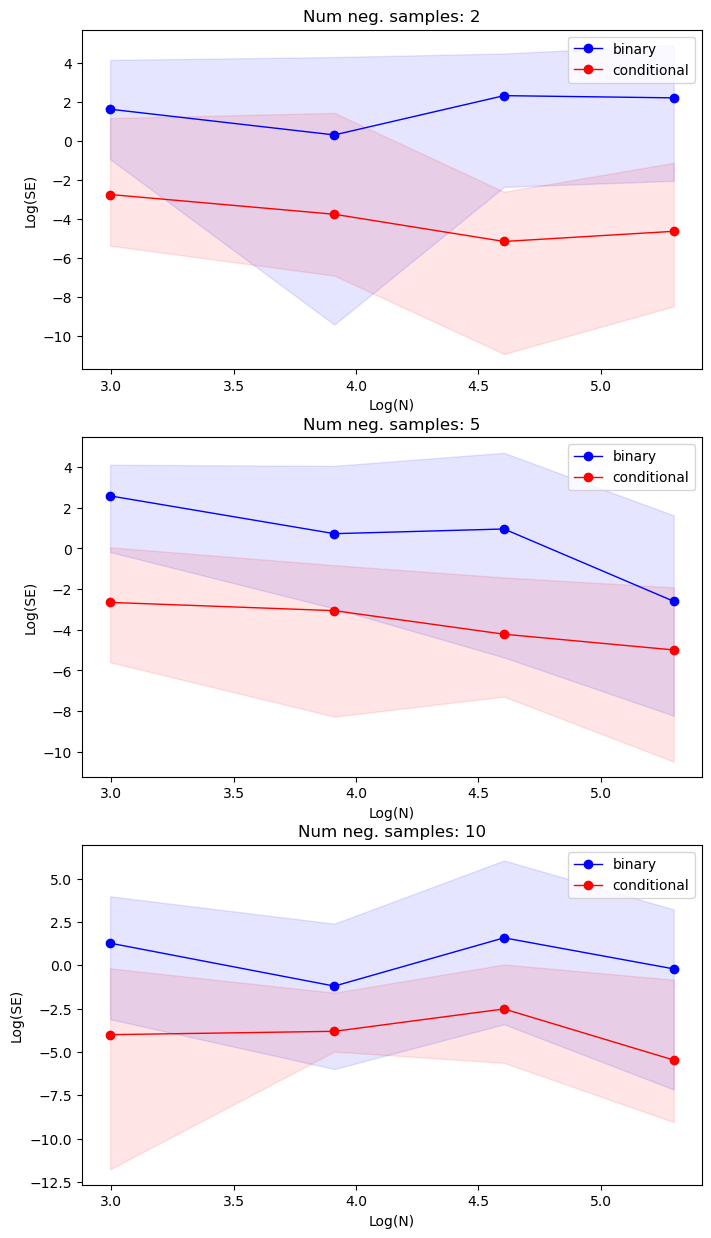

In [11]:
# Visualise results

error_res = np.load("res/final_param_error_ring_model_all.npy")

fig, ax = plt.subplots(len(num_neg_samples), 1, figsize=(8, 15))
colors = ['b', 'r']

log_num_samples = np.log(np.array(num_samples))
for j, axis in enumerate(ax):
    for k, (crit, lab) in enumerate(zip(criteria, crit_labels)):
        plot_res(log_num_samples, np.log(error_res[:, j, k, :]), lab, colors[k], axis)
        
    axis.set_title("Num neg. samples: {}".format(num_neg_samples[j]))    
    axis.set_xlabel("Log(N)")
    axis.set_ylabel("Log(SE)")
    axis.legend()
        
plt.show()